In [ ]:
"""
* CS-370 | Current/ Emerging Trends in Computer Science - 2024
* Author:              Ryan Hatch
* Date of Development: Mon Nov 24th 06:26:26 2024 
* Last Modified:       Tues Dec 30rd 12:21:21 2024
* Version:             1.2
"""

# *Treasure Hunt Game Notebook*
<hr>

##### The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. The pirate will try to find the optimal path to the treasure using deep Q-learning. 
<!-- While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. -->
##### The first class, `TreasureMaze.py`, represents the environment, which includes a maze object defined as a matrix. The second class, `GameExperience.py`, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called `"exploration"`. 

<!-- This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header. -->

<!-- First, read and review the next few code and instruction blocks to understand the code that you have been given. -->

In [41]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

#### The following code block contains an 8x8 matrix that will be used as a maze object:

In [42]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

#### This helper function allows a visual representation of the maze object:

In [43]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

##### The pirate agent can move in four directions: left, right, up, and down.

##### While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths.

##### This is called `exploration` and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [44]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor (epsilon)
epsilon = 0.1

# Actions dictionary for easy readability
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

# Number of possible actions
num_actions = len(actions_dict)


#### The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


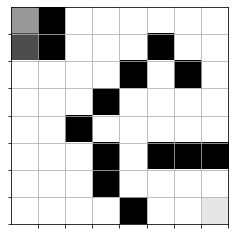

In [45]:
# qmaze = TreasureMaze(maze)
# envstate, reward, game_status = qmaze.act(DOWN)
# print("reward=", reward)
# show(qmaze)

qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

#### This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [ ]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

# def play_game(model, qmaze, pirate_cell):
#     qmaze.reset(pirate_cell)
#     envstate = qmaze.observe()
#     while True:
#         prev_envstate = envstate
#         # get next action
#         q = model.predict(prev_envstate)
#         action = np.argmax(q[0])

#         # apply action, get rewards and new state
#         envstate, reward, game_status = qmaze.act(action)
#         if game_status == 'win':
#             return True
#         elif game_status == 'lose':
#             return False

#### This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. 
#### In this case, your training would not yield any result. 
<!-- The provided maze in this notebook ensures that there is a path to win and you can run this method to check. -->

In [47]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False

In [48]:
def build_model(maze):
    """
    Builds a neural network model using Keras Sequential API.
    
    Parameters:
    - maze: The maze environment as a NumPy array.
    
    Returns:
    - model: Compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model


# def build_model(maze):
#     model = Sequential()
#     model.add(Dense(maze.size, input_shape=(maze.size,)))
#     model.add(PReLU())
#     model.add(Dense(maze.size))
#     model.add(PReLU())
#     model.add(Dense(num_actions))
#     model.compile(optimizer='adam', loss='mse')
#     return model

<!-- ## TODO: Complete the Q-Training Algorithm Code Block -->

#### The Q-learning algorithm is a model-free, reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model of the environment and can handle problems with stochastic transitions and rewards without requiring adaptations. 

#### *The goal of this model is to be trained and then used to find the treasure in the maze.*

<!-- 
#### This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

#### You will need to complete the section starting with #pseudocode. The pseudocode has been included for you. -->

In [ ]:
def qtrain(model, maze, **opt):
    """
    Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
    Parameters:
    - model: The neural network model to be trained.
    - maze: The maze environment as a NumPy array.
    - **opt: Optional parameters including:
        - n_epoch: Number of training epochs (default: 15000)
        - max_memory: Maximum number of episodes to store in memory (default: 1000)
        - data_size: Number of samples to train on per epoch (default: 50)
        - epsilon: Initial exploration factor (default: 0.1)
    
    Returns:
    - seconds: Total training time in seconds.
    """
    
    # Define the format_time function within qtrain
    def format_time(seconds):
        """
        Converts a time duration from seconds to a human-readable string.

        Parameters:
        - seconds (float): Time duration in seconds.

        Returns:
        - str: Human-readable time string.
        """
        if seconds < 60:
            return f"{seconds:.1f} seconds"
        elif seconds < 3600:
            minutes = seconds / 60
            return f"{minutes:.2f} minutes"
        else:
            hours = seconds / 3600
            return f"{hours:.2f} hours"

    # Retrieve optional parameters or set to default values
    n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
    max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
    data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    epsilon = opt.get('epsilon', 0.1)            # Initial exploration factor
    
    # Record the start time to monitor training duration
    start_time = datetime.datetime.now()
    
    #* Initialize the maze environment
    qmaze = TreasureMaze(maze)
    
    # Initialize the experience replay memory
    experience = GameExperience(model, max_memory=max_memory)
    
    #* Initialize variables to track training progress
    win_history = []                  # History of game outcomes (1 for win, 0 for loss)
    hsize = qmaze.maze.size // 2      # Window size for calculating win rate
    win_rate = 0.0                    # Current win rate
    
    # Iterate over each epoch
    for epoch in range(n_epoch):
        # Randomly select a free cell as the pirate's starting position
        agent_cell = random.choice(qmaze.free_cells)
        
        # Reset the maze environment with the pirate at the selected starting position
        qmaze.reset(agent_cell)
        
        # Observe the current state of the environment
        envstate = qmaze.observe()
        
        # Initialize variables for the current episode
        game_over = False               # Flag to determine if the game has ended
        n_episodes = 0                  # Number of steps taken in the current epoch
        win = False                     # Flag to indicate if the current episode is a win
        
        # Continue interacting with the environment until the game is over
        while not game_over:
            # Store the previous state for experience replay
            prev_envstate = envstate.copy()
            
            # Decide whether to explore or exploit based on the epsilon-greedy strategy
            if random.random() < epsilon:
                #* Exploration: choose a random valid action
                valid_actions = qmaze.valid_actions()
                if valid_actions:
                    action = random.choice(valid_actions)
                else:
                    # No valid actions available; the game is blocked
                    action = None
            else:
                #* Exploitation: choose the best action based on current Q-values
                q_values = experience.predict(prev_envstate)
                
                # Retrieve valid actions to mask invalid ones
                valid_actions = qmaze.valid_actions()
                if valid_actions:
                    # Initialize Q-values for all actions as -infinity
                    q_values_invalid = np.full(num_actions, -np.inf)
                    # Assign actual Q-values to valid actions
                    q_values_invalid[valid_actions] = q_values[valid_actions]
                    # Select the action with the highest Q-value among valid actions
                    action = np.argmax(q_values_invalid)
                else:
                    # No valid actions available; the game is blocked
                    action = None
            
            # Execute the chosen action in the environment
            if action is not None:
                envstate, reward, game_status = qmaze.act(action)
            else:
                # Assign a penalty if the agent is blocked
                game_status = 'lose'
                reward = -1.0  # Penalty for being blocked
            
            # Increment the number of steps taken
            n_episodes += 1
            
            # Determine if the game has ended
            game_over = game_status in ['win', 'lose']
            
            # Store the transition (episode) in experience replay memory
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            
            # Update the win history if the game has ended
            if game_over:
                win = 1 if game_status == 'win' else 0
                win_history.append(win)
        
        # Train the neural network model if enough experiences are available
        if len(experience.memory) >= data_size:
            # Retrieve a batch of experiences for training
            inputs, targets = experience.get_data(data_size=data_size)
            
            # Train the model on the retrieved batch
            history = model.fit(inputs, targets, epochs=1, verbose=0)
            
            # Extract the loss value from the training history
            loss = history.history['loss'][0]
        else:
            # Not enough experiences to train; set loss to None
            loss = None
        
        # Calculate the win rate over the most recent hsize episodes
        if len(win_history) >= hsize:
            recent_wins = win_history[-hsize:]
            win_rate = sum(recent_wins) / hsize
        else:
            recent_wins = win_history
            win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
        # Calculate the elapsed time since training started
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        
        # Prepare the template for epoch information display
        template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
        # Display loss as 0.0 if it's None to avoid formatting issues
        loss_display = loss if loss is not None else 0.0
        
        # Print the current epoch's training information
        print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
        # Gradually decrease the exploration factor epsilon if the win rate is high
        if win_rate > 0.9:
            epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
        # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
        if win_rate == 1.0 and completion_check(model, qmaze):
            print("Reached 100% win rate at epoch: {}".format(epoch+1))
            break
    
    # Calculate the total training time
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    
    # Print the training summary
    print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
    return seconds


In [ ]:
#
#* Version 2.2
# def qtrain(model, maze, **opt):
#     """
#     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
#     Parameters:
#     - model: The neural network model to be trained.
#     - maze: The maze environment as a NumPy array.
#     - **opt: Optional parameters including:
#         - n_epoch: Number of training epochs (default: 15000)
#         - max_memory: Maximum number of episodes to store in memory (default: 1000)
#         - data_size: Number of samples to train on per epoch (default: 50)
    
#     Returns:
#     - seconds: Total training time in seconds.
#     """
    
#     # Access the global exploration factor
#     global epsilon 
    
#     # Retrieve optional parameters or set to default values
#     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
#     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
#     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
#     # Record the start time to monitor training duration
#     start_time = datetime.datetime.now()
    
#     # Initialize the maze environment
#     qmaze = TreasureMaze(maze)
    
#     # Initialize the experience replay memory
#     experience = GameExperience(model, max_memory=max_memory)
    
#     # Initialize variables to track training progress
#     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
#     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
#     win_rate = 0.0                     # Current win rate
    
#     # Iterate over each epoch
#     for epoch in range(n_epoch):
#         # Randomly select a free cell as the pirate's starting position
#         agent_cell = random.choice(qmaze.free_cells)
        
#         # Reset the maze environment with the pirate at the selected starting position
#         qmaze.reset(agent_cell)
        
#         # Observe the current state of the environment
#         envstate = qmaze.observe()
        
#         # Initialize variables for the current episode
#         game_over = False               # Flag to determine if the game has ended
#         n_episodes = 0                  # Number of steps taken in the current epoch
#         win = False                     # Flag to indicate if the current episode is a win
        
#         # Continue interacting with the environment until the game is over
#         while not game_over:
#             # Store the previous state for experience replay
#             prev_envstate = envstate.copy()
            
#             # Decide whether to explore or exploit based on epsilon-greedy strategy
#             if random.random() < epsilon:
#                 # Exploration: choose a random valid action
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     action = random.choice(valid_actions)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
#             else:
#                 # Exploitation: choose the best action based on current Q-values
#                 q_values = experience.predict(prev_envstate)
                
#                 # Retrieve valid actions to mask invalid ones
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     # Initialize Q-values for all actions as -infinity
#                     q_values_invalid = np.full(num_actions, -np.inf)
#                     # Assign actual Q-values to valid actions
#                     q_values_invalid[valid_actions] = q_values[valid_actions]
#                     # Select the action with the highest Q-value among valid actions
#                     action = np.argmax(q_values_invalid)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
            
#             # Execute the chosen action in the environment
#             if action is not None:
#                 envstate, reward, game_status = qmaze.act(action)
#             else:
#                 # Assign a penalty if the agent is blocked
#                 game_status = 'lose'
#                 reward = -1.0  # Penalty for being blocked
            
#             # Increment the number of steps taken
#             n_episodes += 1
            
#             # Determine if the game has ended
#             game_over = game_status in ['win', 'lose']
            
#             # Store the transition (episode) in experience replay memory
#             episode = [prev_envstate, action, reward, envstate, game_over]
#             experience.remember(episode)
            
#             # Update the win history if the game has ended
#             if game_over:
#                 win = 1 if game_status == 'win' else 0
#                 win_history.append(win)
        
#         # Train the neural network model if enough experiences are available
#         if len(experience.memory) >= data_size:
#             # Retrieve a batch of experiences for training
#             inputs, targets = experience.get_data(data_size=data_size)
            
#             # Train the model on the retrieved batch
#             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
#             # Extract the loss value from the training history
#             loss = history.history['loss'][0]
#         else:
#             # Not enough experiences to train; set loss to None
#             loss = None
        
#         # Calculate the win rate over the most recent hsize episodes
#         if len(win_history) >= hsize:
#             recent_wins = win_history[-hsize:]
#             win_rate = sum(recent_wins) / hsize
#         else:
#             recent_wins = win_history
#             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
#         # Calculate the elapsed time since training started
#         dt = datetime.datetime.now() - start_time
#         t = format_time(dt.total_seconds())
        
#         # Prepare the template for epoch information display
#         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
#         # Display loss as 0.0 if it's None to avoid formatting issues
#         loss_display = loss if loss is not None else 0.0
        
#         # Print the current epoch's training information
#         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
#         # Gradually decrease the exploration factor epsilon if the win rate is high
#         if win_rate > 0.9:
#             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
#         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
#         if win_rate == 1.0 and completion_check(model, qmaze):
#             print("Reached 100% win rate at epoch: {}".format(epoch+1))
#             break
    
#     # Calculate the total training time
#     dt = datetime.datetime.now() - start_time
#     seconds = dt.total_seconds()
#     t = format_time(seconds)
    
#     # Print the training summary
#     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
#     return seconds

### *Test Your Model*

#### Now we will start testing the deep Q-learning implementation. To begin, select `Cell`, then `Run All` from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

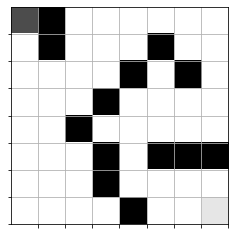

In [ ]:
# Initialize the TreasureMaze environment
qmaze = TreasureMaze(maze)
show(qmaze)

# qmaze = TreasureMaze(maze)

#### In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
# Train the model using deep Q-learning
model = build_model(maze)
training_time = qtrain(model, maze, n_epoch=10000, max_memory=8*maze.size, data_size=32)

# training_time = qtrain(model, maze, n_epoch=10000, max_memory=8*maze.size, data_size=32)

# qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 00001/10000 | Loss: 0.0377 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 1.8 seconds
Epoch: 00002/10000 | Loss: 0.1136 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 2.1 seconds
Epoch: 00003/10000 | Loss: 0.0996 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | Time: 2.4 seconds
Epoch: 00004/10000 | Loss: 0.0529 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 2.7 seconds
Epoch: 00005/10000 | Loss: 0.0331 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 2.9 seconds
Epoch: 00006/10000 | Loss: 0.0466 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 3.2 seconds
Epoch: 00007/10000 | Loss: 0.0127 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | Time: 3.4 seconds
Epoch: 00008/10000 | Loss: 0.0102 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | Time: 3.7 seconds
Epoch: 00009/10000 | Loss: 0.0097 | Episodes: 132 | Win count: 0 | Win rate: 0.000 | Time: 4.0 seconds
Epoch: 00010/10000 | Loss: 0.0100 | Episodes: 135 | Win count: 0 | Win ra

Epoch: 00082/10000 | Loss: 0.0047 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 21.7 seconds
Epoch: 00083/10000 | Loss: 0.0059 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 22.0 seconds
Epoch: 00084/10000 | Loss: 0.0069 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 22.3 seconds
Epoch: 00085/10000 | Loss: 0.0034 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 22.5 seconds
Epoch: 00086/10000 | Loss: 0.0043 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 22.8 seconds
Epoch: 00087/10000 | Loss: 0.0410 | Episodes: 144 | Win count: 4 | Win rate: 0.125 | Time: 23.0 seconds
Epoch: 00088/10000 | Loss: 0.0044 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 23.3 seconds
Epoch: 00089/10000 | Loss: 0.0079 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 23.6 seconds
Epoch: 00090/10000 | Loss: 0.0048 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 23.9 seconds
Epoch: 00091/10000 | Loss: 0.0027 | Episodes: 133 | Win count: 4

Epoch: 00161/10000 | Loss: 0.0030 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 41.1 seconds
Epoch: 00162/10000 | Loss: 0.0026 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 41.4 seconds
Epoch: 00163/10000 | Loss: 0.0017 | Episodes: 144 | Win count: 4 | Win rate: 0.125 | Time: 41.6 seconds
Epoch: 00164/10000 | Loss: 0.0011 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 41.9 seconds
Epoch: 00165/10000 | Loss: 0.0347 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 42.2 seconds
Epoch: 00166/10000 | Loss: 0.0017 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 42.4 seconds
Epoch: 00167/10000 | Loss: 0.0024 | Episodes: 144 | Win count: 3 | Win rate: 0.094 | Time: 42.7 seconds
Epoch: 00168/10000 | Loss: 0.0017 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 43.0 seconds
Epoch: 00169/10000 | Loss: 0.0334 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 43.3 seconds
Epoch: 00170/10000 | Loss: 0.0022 | Episodes: 136 | Win count: 2

Epoch: 00240/10000 | Loss: 0.0037 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 1.00 minutes
Epoch: 00241/10000 | Loss: 0.0030 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 1.01 minutes
Epoch: 00242/10000 | Loss: 0.0027 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 1.02 minutes
Epoch: 00243/10000 | Loss: 0.0489 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 1.02 minutes
Epoch: 00244/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 1.03 minutes
Epoch: 00245/10000 | Loss: 0.0020 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 1.03 minutes
Epoch: 00246/10000 | Loss: 0.0016 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 1.04 minutes
Epoch: 00247/10000 | Loss: 0.0020 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 1.04 minutes
Epoch: 00248/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 1.05 minutes
Epoch: 00249/10000 | Loss: 0.0021 | Episodes: 136 | Win count: 2

Epoch: 00320/10000 | Loss: 0.0012 | Episodes: 141 | Win count: 4 | Win rate: 0.125 | Time: 1.35 minutes
Epoch: 00321/10000 | Loss: 0.0050 | Episodes: 60 | Win count: 5 | Win rate: 0.156 | Time: 1.35 minutes
Epoch: 00322/10000 | Loss: 0.0670 | Episodes: 37 | Win count: 6 | Win rate: 0.188 | Time: 1.35 minutes
Epoch: 00323/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 1.36 minutes
Epoch: 00324/10000 | Loss: 0.0013 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 1.36 minutes
Epoch: 00325/10000 | Loss: 0.1130 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 1.36 minutes
Epoch: 00326/10000 | Loss: 0.0022 | Episodes: 81 | Win count: 7 | Win rate: 0.219 | Time: 1.37 minutes
Epoch: 00327/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 1.37 minutes
Epoch: 00328/10000 | Loss: 0.0006 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 1.37 minutes
Epoch: 00329/10000 | Loss: 0.0503 | Episodes: 133 | Win count: 7 | 

Epoch: 00399/10000 | Loss: 0.0024 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 1.64 minutes
Epoch: 00400/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 1.65 minutes
Epoch: 00401/10000 | Loss: 0.0397 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 1.65 minutes
Epoch: 00402/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 1.66 minutes
Epoch: 00403/10000 | Loss: 0.0033 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 1.66 minutes
Epoch: 00404/10000 | Loss: 0.0036 | Episodes: 88 | Win count: 7 | Win rate: 0.219 | Time: 1.66 minutes
Epoch: 00405/10000 | Loss: 0.0034 | Episodes: 144 | Win count: 6 | Win rate: 0.188 | Time: 1.67 minutes
Epoch: 00406/10000 | Loss: 0.0023 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 1.67 minutes
Epoch: 00407/10000 | Loss: 0.0018 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 1.68 minutes
Epoch: 00408/10000 | Loss: 0.0596 | Episodes: 133 | Win count: 4 

Epoch: 00478/10000 | Loss: 0.0018 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 1.99 minutes
Epoch: 00479/10000 | Loss: 0.0027 | Episodes: 1 | Win count: 2 | Win rate: 0.062 | Time: 1.99 minutes
Epoch: 00480/10000 | Loss: 0.0019 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 1.99 minutes
Epoch: 00481/10000 | Loss: 0.0019 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 2.00 minutes
Epoch: 00482/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 2.00 minutes
Epoch: 00483/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 2.01 minutes
Epoch: 00484/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 2.01 minutes
Epoch: 00485/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 2.02 minutes
Epoch: 00486/10000 | Loss: 0.0021 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 2.02 minutes
Epoch: 00487/10000 | Loss: 0.0018 | Episodes: 32 | Win count: 2 | 

Epoch: 00557/10000 | Loss: 0.0041 | Episodes: 73 | Win count: 5 | Win rate: 0.156 | Time: 2.30 minutes
Epoch: 00558/10000 | Loss: 0.0029 | Episodes: 144 | Win count: 5 | Win rate: 0.156 | Time: 2.30 minutes
Epoch: 00559/10000 | Loss: 0.0032 | Episodes: 141 | Win count: 5 | Win rate: 0.156 | Time: 2.31 minutes
Epoch: 00560/10000 | Loss: 0.0047 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 2.31 minutes
Epoch: 00561/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 2.32 minutes
Epoch: 00562/10000 | Loss: 0.0030 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 2.32 minutes
Epoch: 00563/10000 | Loss: 0.0029 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 2.32 minutes
Epoch: 00564/10000 | Loss: 0.0030 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 2.33 minutes
Epoch: 00565/10000 | Loss: 0.0225 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 2.33 minutes
Epoch: 00566/10000 | Loss: 0.0026 | Episodes: 134 | Win count: 5 

Epoch: 00637/10000 | Loss: 0.1472 | Episodes: 140 | Win count: 4 | Win rate: 0.125 | Time: 2.61 minutes
Epoch: 00638/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 2.62 minutes
Epoch: 00639/10000 | Loss: 0.0019 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 2.62 minutes
Epoch: 00640/10000 | Loss: 0.0015 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 2.62 minutes
Epoch: 00641/10000 | Loss: 0.0011 | Episodes: 1 | Win count: 6 | Win rate: 0.188 | Time: 2.62 minutes
Epoch: 00642/10000 | Loss: 0.0022 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 2.63 minutes
Epoch: 00643/10000 | Loss: 0.0014 | Episodes: 8 | Win count: 7 | Win rate: 0.219 | Time: 2.63 minutes
Epoch: 00644/10000 | Loss: 0.0009 | Episodes: 71 | Win count: 8 | Win rate: 0.250 | Time: 2.63 minutes
Epoch: 00645/10000 | Loss: 0.0023 | Episodes: 138 | Win count: 8 | Win rate: 0.250 | Time: 2.64 minutes
Epoch: 00646/10000 | Loss: 0.2529 | Episodes: 57 | Win count: 9 | Win r

Epoch: 00716/10000 | Loss: 0.0006 | Episodes: 143 | Win count: 5 | Win rate: 0.156 | Time: 2.92 minutes
Epoch: 00717/10000 | Loss: 0.0870 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 2.93 minutes
Epoch: 00718/10000 | Loss: 0.0022 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 2.93 minutes
Epoch: 00719/10000 | Loss: 0.0908 | Episodes: 50 | Win count: 6 | Win rate: 0.188 | Time: 2.93 minutes
Epoch: 00720/10000 | Loss: 0.0034 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 2.94 minutes
Epoch: 00721/10000 | Loss: 0.0016 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 2.94 minutes
Epoch: 00722/10000 | Loss: 0.0039 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 2.95 minutes
Epoch: 00723/10000 | Loss: 0.0039 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 2.95 minutes
Epoch: 00724/10000 | Loss: 0.0027 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 2.96 minutes
Epoch: 00725/10000 | Loss: 0.0025 | Episodes: 135 | Win count: 3 

Epoch: 00795/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 3.24 minutes
Epoch: 00796/10000 | Loss: 0.0031 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 3.24 minutes
Epoch: 00797/10000 | Loss: 0.1609 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 3.25 minutes
Epoch: 00798/10000 | Loss: 0.0764 | Episodes: 144 | Win count: 5 | Win rate: 0.156 | Time: 3.25 minutes
Epoch: 00799/10000 | Loss: 0.0014 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 3.26 minutes
Epoch: 00800/10000 | Loss: 0.0697 | Episodes: 140 | Win count: 5 | Win rate: 0.156 | Time: 3.26 minutes
Epoch: 00801/10000 | Loss: 0.0019 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 3.26 minutes
Epoch: 00802/10000 | Loss: 0.0661 | Episodes: 2 | Win count: 6 | Win rate: 0.188 | Time: 3.26 minutes
Epoch: 00803/10000 | Loss: 0.0024 | Episodes: 137 | Win count: 6 | Win rate: 0.188 | Time: 3.27 minutes
Epoch: 00804/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 5 |

Epoch: 00874/10000 | Loss: 0.0074 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 3.55 minutes
Epoch: 00875/10000 | Loss: 0.0032 | Episodes: 1 | Win count: 6 | Win rate: 0.188 | Time: 3.55 minutes
Epoch: 00876/10000 | Loss: 0.0031 | Episodes: 141 | Win count: 6 | Win rate: 0.188 | Time: 3.56 minutes
Epoch: 00877/10000 | Loss: 0.0402 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 3.56 minutes
Epoch: 00878/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 3.57 minutes
Epoch: 00879/10000 | Loss: 0.0022 | Episodes: 142 | Win count: 5 | Win rate: 0.156 | Time: 3.57 minutes
Epoch: 00880/10000 | Loss: 0.0022 | Episodes: 13 | Win count: 5 | Win rate: 0.156 | Time: 3.57 minutes
Epoch: 00881/10000 | Loss: 0.0026 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 3.58 minutes
Epoch: 00882/10000 | Loss: 0.0034 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 3.58 minutes
Epoch: 00883/10000 | Loss: 0.0030 | Episodes: 139 | Win count: 4 | 

Epoch: 00953/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 3.85 minutes
Epoch: 00954/10000 | Loss: 0.0039 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 3.86 minutes
Epoch: 00955/10000 | Loss: 0.1473 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 3.86 minutes
Epoch: 00956/10000 | Loss: 0.0958 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 3.86 minutes
Epoch: 00957/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 3.87 minutes
Epoch: 00958/10000 | Loss: 0.0084 | Episodes: 1 | Win count: 6 | Win rate: 0.188 | Time: 3.87 minutes
Epoch: 00959/10000 | Loss: 0.0470 | Episodes: 143 | Win count: 6 | Win rate: 0.188 | Time: 3.87 minutes
Epoch: 00960/10000 | Loss: 0.0543 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 3.88 minutes
Epoch: 00961/10000 | Loss: 0.0262 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 3.88 minutes
Epoch: 00962/10000 | Loss: 0.0067 | Episodes: 139 | Win count: 6 | W

Epoch: 01032/10000 | Loss: 0.0345 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 4.18 minutes
Epoch: 01033/10000 | Loss: 0.0021 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 4.19 minutes
Epoch: 01034/10000 | Loss: 0.0035 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 4.19 minutes
Epoch: 01035/10000 | Loss: 0.0035 | Episodes: 144 | Win count: 2 | Win rate: 0.062 | Time: 4.20 minutes
Epoch: 01036/10000 | Loss: 0.0043 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 4.20 minutes
Epoch: 01037/10000 | Loss: 0.0415 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 4.20 minutes
Epoch: 01038/10000 | Loss: 0.0035 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 4.21 minutes
Epoch: 01039/10000 | Loss: 0.0033 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 4.21 minutes
Epoch: 01040/10000 | Loss: 0.0028 | Episodes: 141 | Win count: 2 | Win rate: 0.062 | Time: 4.22 minutes
Epoch: 01041/10000 | Loss: 0.0511 | Episodes: 134 | Win count: 2

Epoch: 01111/10000 | Loss: 0.0014 | Episodes: 132 | Win count: 0 | Win rate: 0.000 | Time: 4.50 minutes
Epoch: 01112/10000 | Loss: 0.0014 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 4.51 minutes
Epoch: 01113/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 4.51 minutes
Epoch: 01114/10000 | Loss: 0.0006 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 4.52 minutes
Epoch: 01115/10000 | Loss: 0.0007 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | Time: 4.52 minutes
Epoch: 01116/10000 | Loss: 0.0019 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | Time: 4.52 minutes
Epoch: 01117/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | Time: 4.53 minutes
Epoch: 01118/10000 | Loss: 0.0015 | Episodes: 136 | Win count: 0 | Win rate: 0.000 | Time: 4.53 minutes
Epoch: 01119/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 4.54 minutes
Epoch: 01120/10000 | Loss: 0.0635 | Episodes: 132 | Win count: 0

Epoch: 01190/10000 | Loss: 0.1159 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 4.84 minutes
Epoch: 01191/10000 | Loss: 0.0034 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 4.84 minutes
Epoch: 01192/10000 | Loss: 0.0037 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 4.84 minutes
Epoch: 01193/10000 | Loss: 0.0031 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 4.85 minutes
Epoch: 01194/10000 | Loss: 0.0027 | Episodes: 129 | Win count: 2 | Win rate: 0.062 | Time: 4.85 minutes
Epoch: 01195/10000 | Loss: 0.0022 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 4.86 minutes
Epoch: 01196/10000 | Loss: 0.0025 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 4.86 minutes
Epoch: 01197/10000 | Loss: 0.0022 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 4.86 minutes
Epoch: 01198/10000 | Loss: 0.0030 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 4.87 minutes
Epoch: 01199/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 2

Epoch: 01269/10000 | Loss: 0.0014 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 5.16 minutes
Epoch: 01270/10000 | Loss: 0.0671 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 5.17 minutes
Epoch: 01271/10000 | Loss: 0.0691 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 5.18 minutes
Epoch: 01272/10000 | Loss: 0.0641 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 5.18 minutes
Epoch: 01273/10000 | Loss: 0.1225 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 5.18 minutes
Epoch: 01274/10000 | Loss: 0.0011 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 5.19 minutes
Epoch: 01275/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 5.20 minutes
Epoch: 01276/10000 | Loss: 0.0538 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 5.20 minutes
Epoch: 01277/10000 | Loss: 0.0025 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 5.21 minutes
Epoch: 01278/10000 | Loss: 0.0015 | Episodes: 139 | Win count: 1

Epoch: 01348/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 5.47 minutes
Epoch: 01349/10000 | Loss: 0.0321 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 5.48 minutes
Epoch: 01350/10000 | Loss: 0.0038 | Episodes: 139 | Win count: 8 | Win rate: 0.250 | Time: 5.48 minutes
Epoch: 01351/10000 | Loss: 0.0047 | Episodes: 141 | Win count: 8 | Win rate: 0.250 | Time: 5.49 minutes
Epoch: 01352/10000 | Loss: 0.0047 | Episodes: 133 | Win count: 8 | Win rate: 0.250 | Time: 5.49 minutes
Epoch: 01353/10000 | Loss: 0.0047 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 5.49 minutes
Epoch: 01354/10000 | Loss: 0.0694 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 5.50 minutes
Epoch: 01355/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 5.50 minutes
Epoch: 01356/10000 | Loss: 0.0416 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 5.51 minutes
Epoch: 01357/10000 | Loss: 0.0429 | Episodes: 135 | Win count: 6

Epoch: 01427/10000 | Loss: 0.0027 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 5.79 minutes
Epoch: 01428/10000 | Loss: 0.0037 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 5.80 minutes
Epoch: 01429/10000 | Loss: 0.0036 | Episodes: 38 | Win count: 6 | Win rate: 0.188 | Time: 5.80 minutes
Epoch: 01430/10000 | Loss: 0.0375 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 5.80 minutes
Epoch: 01431/10000 | Loss: 0.0034 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 5.81 minutes
Epoch: 01432/10000 | Loss: 0.0027 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 5.81 minutes
Epoch: 01433/10000 | Loss: 0.0028 | Episodes: 144 | Win count: 6 | Win rate: 0.188 | Time: 5.82 minutes
Epoch: 01434/10000 | Loss: 0.0030 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 5.82 minutes
Epoch: 01435/10000 | Loss: 0.0032 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 5.82 minutes
Epoch: 01436/10000 | Loss: 0.0031 | Episodes: 133 | Win count: 6 

Epoch: 01506/10000 | Loss: 0.0963 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 6.10 minutes
Epoch: 01507/10000 | Loss: 0.0038 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 6.10 minutes
Epoch: 01508/10000 | Loss: 0.1937 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 6.11 minutes
Epoch: 01509/10000 | Loss: 0.0015 | Episodes: 9 | Win count: 6 | Win rate: 0.188 | Time: 6.11 minutes
Epoch: 01510/10000 | Loss: 0.0019 | Episodes: 20 | Win count: 7 | Win rate: 0.219 | Time: 6.11 minutes
Epoch: 01511/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 6.12 minutes
Epoch: 01512/10000 | Loss: 0.0009 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 6.12 minutes
Epoch: 01513/10000 | Loss: 0.0020 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 6.12 minutes
Epoch: 01514/10000 | Loss: 0.0016 | Episodes: 74 | Win count: 8 | Win rate: 0.250 | Time: 6.13 minutes
Epoch: 01515/10000 | Loss: 0.0627 | Episodes: 137 | Win count: 8 | W

Epoch: 01585/10000 | Loss: 0.0013 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 6.40 minutes
Epoch: 01586/10000 | Loss: 0.0542 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 6.40 minutes
Epoch: 01587/10000 | Loss: 0.0013 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 6.41 minutes
Epoch: 01588/10000 | Loss: 0.0011 | Episodes: 130 | Win count: 6 | Win rate: 0.188 | Time: 6.41 minutes
Epoch: 01589/10000 | Loss: 0.0014 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 6.42 minutes
Epoch: 01590/10000 | Loss: 0.0018 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 6.42 minutes
Epoch: 01591/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 6.43 minutes
Epoch: 01592/10000 | Loss: 0.0013 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 6.43 minutes
Epoch: 01593/10000 | Loss: 0.0025 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 6.43 minutes
Epoch: 01594/10000 | Loss: 0.0740 | Episodes: 137 | Win count: 6

Epoch: 01664/10000 | Loss: 0.0036 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 6.74 minutes
Epoch: 01665/10000 | Loss: 0.0044 | Episodes: 2 | Win count: 3 | Win rate: 0.094 | Time: 6.74 minutes
Epoch: 01666/10000 | Loss: 0.0032 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 6.74 minutes
Epoch: 01667/10000 | Loss: 0.0496 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 6.75 minutes
Epoch: 01668/10000 | Loss: 0.0039 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 6.75 minutes
Epoch: 01669/10000 | Loss: 0.0022 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 6.76 minutes
Epoch: 01670/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 6.76 minutes
Epoch: 01671/10000 | Loss: 0.0344 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 6.76 minutes
Epoch: 01672/10000 | Loss: 0.0371 | Episodes: 5 | Win count: 4 | Win rate: 0.125 | Time: 6.77 minutes
Epoch: 01673/10000 | Loss: 0.0333 | Episodes: 137 | Win count: 4 | W

Epoch: 01743/10000 | Loss: 0.0604 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 7.06 minutes
Epoch: 01744/10000 | Loss: 0.0610 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 7.06 minutes
Epoch: 01745/10000 | Loss: 0.0649 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 7.07 minutes
Epoch: 01746/10000 | Loss: 0.0019 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 7.07 minutes
Epoch: 01747/10000 | Loss: 0.1833 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 7.07 minutes
Epoch: 01748/10000 | Loss: 0.0567 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 7.08 minutes
Epoch: 01749/10000 | Loss: 0.0035 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 7.08 minutes
Epoch: 01750/10000 | Loss: 0.0561 | Episodes: 140 | Win count: 1 | Win rate: 0.031 | Time: 7.09 minutes
Epoch: 01751/10000 | Loss: 0.0560 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 7.09 minutes
Epoch: 01752/10000 | Loss: 0.0533 | Episodes: 143 | Win count: 0

Epoch: 01822/10000 | Loss: 0.0307 | Episodes: 130 | Win count: 5 | Win rate: 0.156 | Time: 7.35 minutes
Epoch: 01823/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 7.36 minutes
Epoch: 01824/10000 | Loss: 0.0334 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 7.36 minutes
Epoch: 01825/10000 | Loss: 0.0036 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 7.36 minutes
Epoch: 01826/10000 | Loss: 0.0035 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 7.37 minutes
Epoch: 01827/10000 | Loss: 0.0025 | Episodes: 142 | Win count: 3 | Win rate: 0.094 | Time: 7.37 minutes
Epoch: 01828/10000 | Loss: 0.0022 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 7.37 minutes
Epoch: 01829/10000 | Loss: 0.0032 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 7.38 minutes
Epoch: 01830/10000 | Loss: 0.0412 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 7.38 minutes
Epoch: 01831/10000 | Loss: 0.0039 | Episodes: 131 | Win count: 2

Epoch: 01901/10000 | Loss: 0.1602 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 7.65 minutes
Epoch: 01902/10000 | Loss: 0.0024 | Episodes: 48 | Win count: 4 | Win rate: 0.125 | Time: 7.65 minutes
Epoch: 01903/10000 | Loss: 0.0709 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 7.66 minutes
Epoch: 01904/10000 | Loss: 0.0645 | Episodes: 130 | Win count: 4 | Win rate: 0.125 | Time: 7.66 minutes
Epoch: 01905/10000 | Loss: 0.0630 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 7.67 minutes
Epoch: 01906/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 7.67 minutes
Epoch: 01907/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 7.68 minutes
Epoch: 01908/10000 | Loss: 0.0029 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 7.68 minutes
Epoch: 01909/10000 | Loss: 0.0026 | Episodes: 131 | Win count: 5 | Win rate: 0.156 | Time: 7.68 minutes
Epoch: 01910/10000 | Loss: 0.0495 | Episodes: 133 | Win count: 4 | 

Epoch: 01980/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 7.95 minutes
Epoch: 01981/10000 | Loss: 0.0008 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 7.95 minutes
Epoch: 01982/10000 | Loss: 0.0010 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 7.95 minutes
Epoch: 01983/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 7.96 minutes
Epoch: 01984/10000 | Loss: 0.0010 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 7.96 minutes
Epoch: 01985/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 7.97 minutes
Epoch: 01986/10000 | Loss: 0.0372 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 7.97 minutes
Epoch: 01987/10000 | Loss: 0.0004 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 7.97 minutes
Epoch: 01988/10000 | Loss: 0.0429 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 7.98 minutes
Epoch: 01989/10000 | Loss: 0.0011 | Episodes: 135 | Win count: 1

Epoch: 02059/10000 | Loss: 0.0043 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 8.25 minutes
Epoch: 02060/10000 | Loss: 0.0038 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 8.26 minutes
Epoch: 02061/10000 | Loss: 0.0016 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 8.26 minutes
Epoch: 02062/10000 | Loss: 0.0353 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 8.26 minutes
Epoch: 02063/10000 | Loss: 0.0005 | Episodes: 10 | Win count: 6 | Win rate: 0.188 | Time: 8.26 minutes
Epoch: 02064/10000 | Loss: 0.0021 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 8.27 minutes
Epoch: 02065/10000 | Loss: 0.0023 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 8.27 minutes
Epoch: 02066/10000 | Loss: 0.0034 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 8.27 minutes
Epoch: 02067/10000 | Loss: 0.0030 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 8.28 minutes
Epoch: 02068/10000 | Loss: 0.0031 | Episodes: 134 | Win count: 6 | 

Epoch: 02138/10000 | Loss: 0.0026 | Episodes: 132 | Win count: 0 | Win rate: 0.000 | Time: 8.57 minutes
Epoch: 02139/10000 | Loss: 0.0192 | Episodes: 7 | Win count: 1 | Win rate: 0.031 | Time: 8.57 minutes
Epoch: 02140/10000 | Loss: 0.0022 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 8.57 minutes
Epoch: 02141/10000 | Loss: 0.0215 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 8.57 minutes
Epoch: 02142/10000 | Loss: 0.0016 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 8.58 minutes
Epoch: 02143/10000 | Loss: 0.0013 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 8.58 minutes
Epoch: 02144/10000 | Loss: 0.0181 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 8.59 minutes
Epoch: 02145/10000 | Loss: 0.0556 | Episodes: 87 | Win count: 2 | Win rate: 0.062 | Time: 8.59 minutes
Epoch: 02146/10000 | Loss: 0.0034 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 8.59 minutes
Epoch: 02147/10000 | Loss: 0.0200 | Episodes: 139 | Win count: 2 | 

Epoch: 02217/10000 | Loss: 0.0012 | Episodes: 130 | Win count: 1 | Win rate: 0.031 | Time: 8.87 minutes
Epoch: 02218/10000 | Loss: 0.0018 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 8.87 minutes
Epoch: 02219/10000 | Loss: 0.0033 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 8.88 minutes
Epoch: 02220/10000 | Loss: 0.1005 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 8.88 minutes
Epoch: 02221/10000 | Loss: 0.0011 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 8.88 minutes
Epoch: 02222/10000 | Loss: 0.0009 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 8.89 minutes
Epoch: 02223/10000 | Loss: 0.0868 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 8.89 minutes
Epoch: 02224/10000 | Loss: 0.0870 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 8.90 minutes
Epoch: 02225/10000 | Loss: 0.0023 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 8.90 minutes
Epoch: 02226/10000 | Loss: 0.0020 | Episodes: 138 | Win count: 1

Epoch: 02296/10000 | Loss: 0.0332 | Episodes: 140 | Win count: 10 | Win rate: 0.312 | Time: 9.18 minutes
Epoch: 02297/10000 | Loss: 0.0024 | Episodes: 140 | Win count: 10 | Win rate: 0.312 | Time: 9.19 minutes
Epoch: 02298/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 9.19 minutes
Epoch: 02299/10000 | Loss: 0.0023 | Episodes: 7 | Win count: 10 | Win rate: 0.312 | Time: 9.19 minutes
Epoch: 02300/10000 | Loss: 0.0026 | Episodes: 131 | Win count: 10 | Win rate: 0.312 | Time: 9.20 minutes
Epoch: 02301/10000 | Loss: 0.0026 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 9.20 minutes
Epoch: 02302/10000 | Loss: 0.0396 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 9.20 minutes
Epoch: 02303/10000 | Loss: 0.0033 | Episodes: 1 | Win count: 9 | Win rate: 0.281 | Time: 9.21 minutes
Epoch: 02304/10000 | Loss: 0.0943 | Episodes: 3 | Win count: 10 | Win rate: 0.312 | Time: 9.21 minutes
Epoch: 02305/10000 | Loss: 0.0024 | Episodes: 140 | Win count: 10

Epoch: 02375/10000 | Loss: 0.0010 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 9.49 minutes
Epoch: 02376/10000 | Loss: 0.0016 | Episodes: 142 | Win count: 2 | Win rate: 0.062 | Time: 9.49 minutes
Epoch: 02377/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 9.50 minutes
Epoch: 02378/10000 | Loss: 0.0026 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 9.50 minutes
Epoch: 02379/10000 | Loss: 0.0583 | Episodes: 38 | Win count: 3 | Win rate: 0.094 | Time: 9.50 minutes
Epoch: 02380/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 9.51 minutes
Epoch: 02381/10000 | Loss: 0.0020 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 9.51 minutes
Epoch: 02382/10000 | Loss: 0.0035 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 9.52 minutes
Epoch: 02383/10000 | Loss: 0.0004 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 9.52 minutes
Epoch: 02384/10000 | Loss: 0.0014 | Episodes: 139 | Win count: 2 

Epoch: 02454/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 9.80 minutes
Epoch: 02455/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 9.80 minutes
Epoch: 02456/10000 | Loss: 0.0024 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 9.80 minutes
Epoch: 02457/10000 | Loss: 0.0028 | Episodes: 95 | Win count: 2 | Win rate: 0.062 | Time: 9.81 minutes
Epoch: 02458/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 9.81 minutes
Epoch: 02459/10000 | Loss: 0.0534 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 9.82 minutes
Epoch: 02460/10000 | Loss: 0.0018 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 9.82 minutes
Epoch: 02461/10000 | Loss: 0.0562 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 9.82 minutes
Epoch: 02462/10000 | Loss: 0.0016 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 9.83 minutes
Epoch: 02463/10000 | Loss: 0.0020 | Episodes: 139 | Win count: 1 

Epoch: 02533/10000 | Loss: 0.0014 | Episodes: 115 | Win count: 4 | Win rate: 0.125 | Time: 10.11 minutes
Epoch: 02534/10000 | Loss: 0.0998 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 10.12 minutes
Epoch: 02535/10000 | Loss: 0.0021 | Episodes: 144 | Win count: 4 | Win rate: 0.125 | Time: 10.12 minutes
Epoch: 02536/10000 | Loss: 0.0023 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 10.13 minutes
Epoch: 02537/10000 | Loss: 0.0026 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 10.13 minutes
Epoch: 02538/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 10.13 minutes
Epoch: 02539/10000 | Loss: 0.0021 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 10.14 minutes
Epoch: 02540/10000 | Loss: 0.0482 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 10.14 minutes
Epoch: 02541/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 10.14 minutes
Epoch: 02542/10000 | Loss: 0.0014 | Episodes: 139 | Win c

Epoch: 02612/10000 | Loss: 0.0016 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 10.42 minutes
Epoch: 02613/10000 | Loss: 0.0943 | Episodes: 2 | Win count: 4 | Win rate: 0.125 | Time: 10.43 minutes
Epoch: 02614/10000 | Loss: 0.0957 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 10.43 minutes
Epoch: 02615/10000 | Loss: 0.0976 | Episodes: 86 | Win count: 4 | Win rate: 0.125 | Time: 10.43 minutes
Epoch: 02616/10000 | Loss: 0.0009 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 10.44 minutes
Epoch: 02617/10000 | Loss: 0.0016 | Episodes: 141 | Win count: 4 | Win rate: 0.125 | Time: 10.44 minutes
Epoch: 02618/10000 | Loss: 0.0026 | Episodes: 146 | Win count: 4 | Win rate: 0.125 | Time: 10.45 minutes
Epoch: 02619/10000 | Loss: 0.0965 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 10.45 minutes
Epoch: 02620/10000 | Loss: 0.0036 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 10.45 minutes
Epoch: 02621/10000 | Loss: 0.0015 | Episodes: 134 | Win co

Epoch: 02691/10000 | Loss: 0.0028 | Episodes: 138 | Win count: 11 | Win rate: 0.344 | Time: 10.72 minutes
Epoch: 02692/10000 | Loss: 0.0369 | Episodes: 138 | Win count: 11 | Win rate: 0.344 | Time: 10.72 minutes
Epoch: 02693/10000 | Loss: 0.0023 | Episodes: 1 | Win count: 12 | Win rate: 0.375 | Time: 10.72 minutes
Epoch: 02694/10000 | Loss: 0.0844 | Episodes: 6 | Win count: 13 | Win rate: 0.406 | Time: 10.73 minutes
Epoch: 02695/10000 | Loss: 0.0378 | Episodes: 134 | Win count: 12 | Win rate: 0.375 | Time: 10.73 minutes
Epoch: 02696/10000 | Loss: 0.0365 | Episodes: 134 | Win count: 12 | Win rate: 0.375 | Time: 10.73 minutes
Epoch: 02697/10000 | Loss: 0.0023 | Episodes: 132 | Win count: 12 | Win rate: 0.375 | Time: 10.74 minutes
Epoch: 02698/10000 | Loss: 0.0030 | Episodes: 61 | Win count: 13 | Win rate: 0.406 | Time: 10.74 minutes
Epoch: 02699/10000 | Loss: 0.0037 | Episodes: 136 | Win count: 12 | Win rate: 0.375 | Time: 10.75 minutes
Epoch: 02700/10000 | Loss: 0.0038 | Episodes: 139 |

Epoch: 02769/10000 | Loss: 0.0037 | Episodes: 138 | Win count: 8 | Win rate: 0.250 | Time: 11.01 minutes
Epoch: 02770/10000 | Loss: 0.0026 | Episodes: 92 | Win count: 9 | Win rate: 0.281 | Time: 11.01 minutes
Epoch: 02771/10000 | Loss: 0.0038 | Episodes: 89 | Win count: 9 | Win rate: 0.281 | Time: 11.01 minutes
Epoch: 02772/10000 | Loss: 0.0267 | Episodes: 140 | Win count: 9 | Win rate: 0.281 | Time: 11.02 minutes
Epoch: 02773/10000 | Loss: 0.0038 | Episodes: 137 | Win count: 8 | Win rate: 0.250 | Time: 11.02 minutes
Epoch: 02774/10000 | Loss: 0.0749 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 11.03 minutes
Epoch: 02775/10000 | Loss: 0.0048 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 11.03 minutes
Epoch: 02776/10000 | Loss: 0.0313 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 11.04 minutes
Epoch: 02777/10000 | Loss: 0.0277 | Episodes: 131 | Win count: 6 | Win rate: 0.188 | Time: 11.05 minutes
Epoch: 02778/10000 | Loss: 0.0018 | Episodes: 41 | Win co

Epoch: 02848/10000 | Loss: 0.0026 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 11.34 minutes
Epoch: 02849/10000 | Loss: 0.0024 | Episodes: 137 | Win count: 4 | Win rate: 0.125 | Time: 11.34 minutes
Epoch: 02850/10000 | Loss: 0.0763 | Episodes: 131 | Win count: 4 | Win rate: 0.125 | Time: 11.34 minutes
Epoch: 02851/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 11.35 minutes
Epoch: 02852/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 4 | Win rate: 0.125 | Time: 11.35 minutes
Epoch: 02853/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 11.36 minutes
Epoch: 02854/10000 | Loss: 0.0007 | Episodes: 141 | Win count: 4 | Win rate: 0.125 | Time: 11.36 minutes
Epoch: 02855/10000 | Loss: 0.0008 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 11.37 minutes
Epoch: 02856/10000 | Loss: 0.0020 | Episodes: 141 | Win count: 3 | Win rate: 0.094 | Time: 11.37 minutes
Epoch: 02857/10000 | Loss: 0.0021 | Episodes: 134 | Win

Epoch: 02927/10000 | Loss: 0.0843 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 11.66 minutes
Epoch: 02928/10000 | Loss: 0.0007 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 11.66 minutes
Epoch: 02929/10000 | Loss: 0.0016 | Episodes: 2 | Win count: 4 | Win rate: 0.125 | Time: 11.66 minutes
Epoch: 02930/10000 | Loss: 0.0032 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 11.67 minutes
Epoch: 02931/10000 | Loss: 0.0018 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 11.67 minutes
Epoch: 02932/10000 | Loss: 0.0011 | Episodes: 142 | Win count: 4 | Win rate: 0.125 | Time: 11.68 minutes
Epoch: 02933/10000 | Loss: 0.0880 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 11.68 minutes
Epoch: 02934/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 11.69 minutes
Epoch: 02935/10000 | Loss: 0.0003 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 11.69 minutes
Epoch: 02936/10000 | Loss: 0.0014 | Episodes: 140 | Win c

Epoch: 03007/10000 | Loss: 0.0409 | Episodes: 143 | Win count: 9 | Win rate: 0.281 | Time: 11.95 minutes
Epoch: 03008/10000 | Loss: 0.0440 | Episodes: 144 | Win count: 9 | Win rate: 0.281 | Time: 11.95 minutes
Epoch: 03009/10000 | Loss: 0.0018 | Episodes: 138 | Win count: 9 | Win rate: 0.281 | Time: 11.96 minutes
Epoch: 03010/10000 | Loss: 0.0020 | Episodes: 133 | Win count: 9 | Win rate: 0.281 | Time: 11.96 minutes
Epoch: 03011/10000 | Loss: 0.0029 | Episodes: 136 | Win count: 9 | Win rate: 0.281 | Time: 11.96 minutes
Epoch: 03012/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 11.97 minutes
Epoch: 03013/10000 | Loss: 0.0460 | Episodes: 12 | Win count: 10 | Win rate: 0.312 | Time: 11.97 minutes
Epoch: 03014/10000 | Loss: 0.0033 | Episodes: 132 | Win count: 10 | Win rate: 0.312 | Time: 11.97 minutes
Epoch: 03015/10000 | Loss: 0.1508 | Episodes: 9 | Win count: 11 | Win rate: 0.344 | Time: 11.97 minutes
Epoch: 03016/10000 | Loss: 0.0027 | Episodes: 138 | Win

Epoch: 03087/10000 | Loss: 0.0462 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 12.25 minutes
Epoch: 03088/10000 | Loss: 0.0030 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 12.26 minutes
Epoch: 03089/10000 | Loss: 0.0024 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 12.26 minutes
Epoch: 03090/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 12.26 minutes
Epoch: 03091/10000 | Loss: 0.0013 | Episodes: 8 | Win count: 6 | Win rate: 0.188 | Time: 12.27 minutes
Epoch: 03092/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 12.27 minutes
Epoch: 03093/10000 | Loss: 0.0008 | Episodes: 130 | Win count: 6 | Win rate: 0.188 | Time: 12.27 minutes
Epoch: 03094/10000 | Loss: 0.0015 | Episodes: 1 | Win count: 7 | Win rate: 0.219 | Time: 12.28 minutes
Epoch: 03095/10000 | Loss: 0.0007 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 12.28 minutes
Epoch: 03096/10000 | Loss: 0.1083 | Episodes: 49 | Win coun

Epoch: 03166/10000 | Loss: 0.0829 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 12.59 minutes
Epoch: 03167/10000 | Loss: 0.0021 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 12.59 minutes
Epoch: 03168/10000 | Loss: 0.0012 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 12.60 minutes
Epoch: 03169/10000 | Loss: 0.0024 | Episodes: 125 | Win count: 3 | Win rate: 0.094 | Time: 12.60 minutes
Epoch: 03170/10000 | Loss: 0.0776 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 12.61 minutes
Epoch: 03171/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 12.61 minutes
Epoch: 03172/10000 | Loss: 0.0010 | Episodes: 85 | Win count: 4 | Win rate: 0.125 | Time: 12.61 minutes
Epoch: 03173/10000 | Loss: 0.0792 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 12.62 minutes
Epoch: 03174/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 12.62 minutes
Epoch: 03175/10000 | Loss: 0.0020 | Episodes: 132 | Win 

Epoch: 03245/10000 | Loss: 0.0006 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 12.92 minutes
Epoch: 03246/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 12.92 minutes
Epoch: 03247/10000 | Loss: 0.0008 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 12.92 minutes
Epoch: 03248/10000 | Loss: 0.0006 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 12.93 minutes
Epoch: 03249/10000 | Loss: 0.0622 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 12.93 minutes
Epoch: 03250/10000 | Loss: 0.0005 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 12.94 minutes
Epoch: 03251/10000 | Loss: 0.0578 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 12.94 minutes
Epoch: 03252/10000 | Loss: 0.0007 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 12.94 minutes
Epoch: 03253/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 12.95 minutes
Epoch: 03254/10000 | Loss: 0.0583 | Episodes: 130 | Win

Epoch: 03324/10000 | Loss: 0.0554 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 13.23 minutes
Epoch: 03325/10000 | Loss: 0.0507 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 13.24 minutes
Epoch: 03326/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 13.24 minutes
Epoch: 03327/10000 | Loss: 0.0008 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 13.25 minutes
Epoch: 03328/10000 | Loss: 0.0007 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 13.25 minutes
Epoch: 03329/10000 | Loss: 0.0551 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 13.26 minutes
Epoch: 03330/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 13.26 minutes
Epoch: 03331/10000 | Loss: 0.0019 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 13.26 minutes
Epoch: 03332/10000 | Loss: 0.0016 | Episodes: 137 | Win count: 4 | Win rate: 0.125 | Time: 13.27 minutes
Epoch: 03333/10000 | Loss: 0.0558 | Episodes: 132 | Win

Epoch: 03403/10000 | Loss: 0.0654 | Episodes: 129 | Win count: 0 | Win rate: 0.000 | Time: 13.58 minutes
Epoch: 03404/10000 | Loss: 0.0648 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 13.58 minutes
Epoch: 03405/10000 | Loss: 0.0018 | Episodes: 130 | Win count: 0 | Win rate: 0.000 | Time: 13.59 minutes
Epoch: 03406/10000 | Loss: 0.0633 | Episodes: 130 | Win count: 0 | Win rate: 0.000 | Time: 13.59 minutes
Epoch: 03407/10000 | Loss: 0.0027 | Episodes: 132 | Win count: 0 | Win rate: 0.000 | Time: 13.60 minutes
Epoch: 03408/10000 | Loss: 0.0023 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | Time: 13.60 minutes
Epoch: 03409/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 13.61 minutes
Epoch: 03410/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 13.61 minutes
Epoch: 03411/10000 | Loss: 0.0023 | Episodes: 136 | Win count: 0 | Win rate: 0.000 | Time: 13.61 minutes
Epoch: 03412/10000 | Loss: 0.0021 | Episodes: 133 | Win

Epoch: 03482/10000 | Loss: 0.0016 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 13.90 minutes
Epoch: 03483/10000 | Loss: 0.0499 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 13.91 minutes
Epoch: 03484/10000 | Loss: 0.0460 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 13.91 minutes
Epoch: 03485/10000 | Loss: 0.0035 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 13.92 minutes
Epoch: 03486/10000 | Loss: 0.0469 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 13.92 minutes
Epoch: 03487/10000 | Loss: 0.0457 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 13.92 minutes
Epoch: 03488/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 13.93 minutes
Epoch: 03489/10000 | Loss: 0.0024 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 13.93 minutes
Epoch: 03490/10000 | Loss: 0.0459 | Episodes: 144 | Win count: 6 | Win rate: 0.188 | Time: 13.94 minutes
Epoch: 03491/10000 | Loss: 0.0026 | Episodes: 135 | Win

Epoch: 03561/10000 | Loss: 0.0730 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 14.22 minutes
Epoch: 03562/10000 | Loss: 0.0045 | Episodes: 106 | Win count: 4 | Win rate: 0.125 | Time: 14.22 minutes
Epoch: 03563/10000 | Loss: 0.0067 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 14.22 minutes
Epoch: 03564/10000 | Loss: 0.0061 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 14.23 minutes
Epoch: 03565/10000 | Loss: 0.0023 | Episodes: 142 | Win count: 4 | Win rate: 0.125 | Time: 14.23 minutes
Epoch: 03566/10000 | Loss: 0.0027 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 14.24 minutes
Epoch: 03567/10000 | Loss: 0.0021 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 14.24 minutes
Epoch: 03568/10000 | Loss: 0.0020 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 14.24 minutes
Epoch: 03569/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 14.25 minutes
Epoch: 03570/10000 | Loss: 0.0030 | Episodes: 134 | Win

Epoch: 03641/10000 | Loss: 0.0012 | Episodes: 24 | Win count: 4 | Win rate: 0.125 | Time: 14.51 minutes
Epoch: 03642/10000 | Loss: 0.0012 | Episodes: 138 | Win count: 4 | Win rate: 0.125 | Time: 14.52 minutes
Epoch: 03643/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 14.52 minutes
Epoch: 03644/10000 | Loss: 0.1425 | Episodes: 74 | Win count: 5 | Win rate: 0.156 | Time: 14.53 minutes
Epoch: 03645/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 14.53 minutes
Epoch: 03646/10000 | Loss: 0.0021 | Episodes: 89 | Win count: 6 | Win rate: 0.188 | Time: 14.53 minutes
Epoch: 03647/10000 | Loss: 0.0025 | Episodes: 114 | Win count: 7 | Win rate: 0.219 | Time: 14.54 minutes
Epoch: 03648/10000 | Loss: 0.0024 | Episodes: 19 | Win count: 8 | Win rate: 0.250 | Time: 14.54 minutes
Epoch: 03649/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 8 | Win rate: 0.250 | Time: 14.54 minutes
Epoch: 03650/10000 | Loss: 0.1388 | Episodes: 133 | Win cou

Epoch: 03720/10000 | Loss: 0.0673 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 14.81 minutes
Epoch: 03721/10000 | Loss: 0.0013 | Episodes: 131 | Win count: 4 | Win rate: 0.125 | Time: 14.82 minutes
Epoch: 03722/10000 | Loss: 0.0009 | Episodes: 130 | Win count: 4 | Win rate: 0.125 | Time: 14.82 minutes
Epoch: 03723/10000 | Loss: 0.0010 | Episodes: 131 | Win count: 3 | Win rate: 0.094 | Time: 14.82 minutes
Epoch: 03724/10000 | Loss: 0.0008 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 14.83 minutes
Epoch: 03725/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 14.83 minutes
Epoch: 03726/10000 | Loss: 0.0002 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 14.84 minutes
Epoch: 03727/10000 | Loss: 0.0828 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 14.84 minutes
Epoch: 03728/10000 | Loss: 0.0003 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 14.85 minutes
Epoch: 03729/10000 | Loss: 0.0013 | Episodes: 134 | Win

Epoch: 03799/10000 | Loss: 0.0023 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | Time: 15.13 minutes
Epoch: 03800/10000 | Loss: 0.0020 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | Time: 15.14 minutes
Epoch: 03801/10000 | Loss: 0.0568 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | Time: 15.14 minutes
Epoch: 03802/10000 | Loss: 0.0022 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | Time: 15.15 minutes
Epoch: 03803/10000 | Loss: 0.0016 | Episodes: 53 | Win count: 1 | Win rate: 0.031 | Time: 15.15 minutes
Epoch: 03804/10000 | Loss: 0.0020 | Episodes: 3 | Win count: 2 | Win rate: 0.062 | Time: 15.15 minutes
Epoch: 03805/10000 | Loss: 0.0023 | Episodes: 140 | Win count: 2 | Win rate: 0.062 | Time: 15.16 minutes
Epoch: 03806/10000 | Loss: 0.0590 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 15.16 minutes
Epoch: 03807/10000 | Loss: 0.0015 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 15.16 minutes
Epoch: 03808/10000 | Loss: 0.0018 | Episodes: 136 | Win co

Epoch: 03878/10000 | Loss: 0.0020 | Episodes: 142 | Win count: 2 | Win rate: 0.062 | Time: 15.46 minutes
Epoch: 03879/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 15.46 minutes
Epoch: 03880/10000 | Loss: 0.0009 | Episodes: 1 | Win count: 3 | Win rate: 0.094 | Time: 15.46 minutes
Epoch: 03881/10000 | Loss: 0.0408 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 15.47 minutes
Epoch: 03882/10000 | Loss: 0.0401 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 15.47 minutes
Epoch: 03883/10000 | Loss: 0.0004 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 15.48 minutes
Epoch: 03884/10000 | Loss: 0.0002 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 15.48 minutes
Epoch: 03885/10000 | Loss: 0.0005 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 15.48 minutes
Epoch: 03886/10000 | Loss: 0.0015 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 15.49 minutes
Epoch: 03887/10000 | Loss: 0.0010 | Episodes: 134 | Win c

Epoch: 03957/10000 | Loss: 0.0505 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 15.76 minutes
Epoch: 03958/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 15.76 minutes
Epoch: 03959/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 15.77 minutes
Epoch: 03960/10000 | Loss: 0.0035 | Episodes: 7 | Win count: 6 | Win rate: 0.188 | Time: 15.77 minutes
Epoch: 03961/10000 | Loss: 0.0005 | Episodes: 110 | Win count: 7 | Win rate: 0.219 | Time: 15.77 minutes
Epoch: 03962/10000 | Loss: 0.0020 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 15.78 minutes
Epoch: 03963/10000 | Loss: 0.0011 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 15.78 minutes
Epoch: 03964/10000 | Loss: 0.0013 | Episodes: 132 | Win count: 7 | Win rate: 0.219 | Time: 15.79 minutes
Epoch: 03965/10000 | Loss: 0.0552 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 15.79 minutes
Epoch: 03966/10000 | Loss: 0.0017 | Episodes: 7 | Win cou

Epoch: 04036/10000 | Loss: 0.0015 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 16.10 minutes
Epoch: 04037/10000 | Loss: 0.0643 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 16.10 minutes
Epoch: 04038/10000 | Loss: 0.0019 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 16.10 minutes
Epoch: 04039/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 16.11 minutes
Epoch: 04040/10000 | Loss: 0.0024 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 16.11 minutes
Epoch: 04041/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 16.12 minutes
Epoch: 04042/10000 | Loss: 0.0675 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 16.12 minutes
Epoch: 04043/10000 | Loss: 0.0021 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 16.13 minutes
Epoch: 04044/10000 | Loss: 0.0753 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 16.13 minutes
Epoch: 04045/10000 | Loss: 0.0014 | Episodes: 18 | Win 

Epoch: 04116/10000 | Loss: 0.0013 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 16.43 minutes
Epoch: 04117/10000 | Loss: 0.0033 | Episodes: 8 | Win count: 2 | Win rate: 0.062 | Time: 16.43 minutes
Epoch: 04118/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 16.43 minutes
Epoch: 04119/10000 | Loss: 0.0513 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 16.44 minutes
Epoch: 04120/10000 | Loss: 0.0519 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 16.44 minutes
Epoch: 04121/10000 | Loss: 0.0021 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 16.44 minutes
Epoch: 04122/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 16.45 minutes
Epoch: 04123/10000 | Loss: 0.0017 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 16.45 minutes
Epoch: 04124/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 16.46 minutes
Epoch: 04125/10000 | Loss: 0.0015 | Episodes: 140 | Win c

Epoch: 04195/10000 | Loss: 0.0009 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 16.75 minutes
Epoch: 04196/10000 | Loss: 0.0194 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 16.75 minutes
Epoch: 04197/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 16.76 minutes
Epoch: 04198/10000 | Loss: 0.0192 | Episodes: 2 | Win count: 7 | Win rate: 0.219 | Time: 16.76 minutes
Epoch: 04199/10000 | Loss: 0.0017 | Episodes: 132 | Win count: 7 | Win rate: 0.219 | Time: 16.77 minutes
Epoch: 04200/10000 | Loss: 0.0022 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 16.77 minutes
Epoch: 04201/10000 | Loss: 0.0009 | Episodes: 1 | Win count: 8 | Win rate: 0.250 | Time: 16.77 minutes
Epoch: 04202/10000 | Loss: 0.0016 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 16.78 minutes
Epoch: 04203/10000 | Loss: 0.0222 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 16.78 minutes
Epoch: 04204/10000 | Loss: 0.0033 | Episodes: 134 | Win cou

Epoch: 04274/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 17.07 minutes
Epoch: 04275/10000 | Loss: 0.0014 | Episodes: 99 | Win count: 3 | Win rate: 0.094 | Time: 17.08 minutes
Epoch: 04276/10000 | Loss: 0.0611 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 17.08 minutes
Epoch: 04277/10000 | Loss: 0.0018 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 17.09 minutes
Epoch: 04278/10000 | Loss: 0.0623 | Episodes: 6 | Win count: 3 | Win rate: 0.094 | Time: 17.09 minutes
Epoch: 04279/10000 | Loss: 0.0014 | Episodes: 114 | Win count: 4 | Win rate: 0.125 | Time: 17.09 minutes
Epoch: 04280/10000 | Loss: 0.0013 | Episodes: 137 | Win count: 4 | Win rate: 0.125 | Time: 17.10 minutes
Epoch: 04281/10000 | Loss: 0.0020 | Episodes: 138 | Win count: 4 | Win rate: 0.125 | Time: 17.10 minutes
Epoch: 04282/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 17.11 minutes
Epoch: 04283/10000 | Loss: 0.0660 | Episodes: 3 | Win coun

Epoch: 04353/10000 | Loss: 0.0023 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 17.36 minutes
Epoch: 04354/10000 | Loss: 0.0639 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 17.36 minutes
Epoch: 04355/10000 | Loss: 0.0021 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 17.37 minutes
Epoch: 04356/10000 | Loss: 0.0014 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 17.37 minutes
Epoch: 04357/10000 | Loss: 0.0644 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 17.38 minutes
Epoch: 04358/10000 | Loss: 0.0627 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 17.38 minutes
Epoch: 04359/10000 | Loss: 0.0013 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 17.39 minutes
Epoch: 04360/10000 | Loss: 0.0688 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 17.39 minutes
Epoch: 04361/10000 | Loss: 0.0682 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 17.40 minutes
Epoch: 04362/10000 | Loss: 0.0009 | Episodes: 136 | Win

Epoch: 04432/10000 | Loss: 0.0009 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | Time: 17.69 minutes
Epoch: 04433/10000 | Loss: 0.0615 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 17.69 minutes
Epoch: 04434/10000 | Loss: 0.0006 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 17.70 minutes
Epoch: 04435/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | Time: 17.70 minutes
Epoch: 04436/10000 | Loss: 0.0021 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 17.71 minutes
Epoch: 04437/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 17.71 minutes
Epoch: 04438/10000 | Loss: 0.0549 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 17.72 minutes
Epoch: 04439/10000 | Loss: 0.0032 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | Time: 17.72 minutes
Epoch: 04440/10000 | Loss: 0.0024 | Episodes: 68 | Win count: 1 | Win rate: 0.031 | Time: 17.73 minutes
Epoch: 04441/10000 | Loss: 0.0538 | Episodes: 139 | Win 

Epoch: 04511/10000 | Loss: 0.0025 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 18.01 minutes
Epoch: 04512/10000 | Loss: 0.0639 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 18.01 minutes
Epoch: 04513/10000 | Loss: 0.0024 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 18.02 minutes
Epoch: 04514/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 18.02 minutes
Epoch: 04515/10000 | Loss: 0.0016 | Episodes: 2 | Win count: 3 | Win rate: 0.094 | Time: 18.02 minutes
Epoch: 04516/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 18.03 minutes
Epoch: 04517/10000 | Loss: 0.0020 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 18.03 minutes
Epoch: 04518/10000 | Loss: 0.1667 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 18.04 minutes
Epoch: 04519/10000 | Loss: 0.0005 | Episodes: 130 | Win count: 1 | Win rate: 0.031 | Time: 18.04 minutes
Epoch: 04520/10000 | Loss: 0.0010 | Episodes: 135 | Win c

Epoch: 04590/10000 | Loss: 0.0008 | Episodes: 121 | Win count: 3 | Win rate: 0.094 | Time: 18.32 minutes
Epoch: 04591/10000 | Loss: 0.0017 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 18.32 minutes
Epoch: 04592/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 18.33 minutes
Epoch: 04593/10000 | Loss: 0.0019 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 18.33 minutes
Epoch: 04594/10000 | Loss: 0.1451 | Episodes: 12 | Win count: 4 | Win rate: 0.125 | Time: 18.33 minutes
Epoch: 04595/10000 | Loss: 0.0746 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 18.34 minutes
Epoch: 04596/10000 | Loss: 0.0657 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 18.34 minutes
Epoch: 04597/10000 | Loss: 0.0021 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 18.35 minutes
Epoch: 04598/10000 | Loss: 0.0007 | Episodes: 21 | Win count: 3 | Win rate: 0.094 | Time: 18.35 minutes
Epoch: 04599/10000 | Loss: 0.0014 | Episodes: 87 | Win co

Epoch: 04669/10000 | Loss: 0.0023 | Episodes: 136 | Win count: 8 | Win rate: 0.250 | Time: 18.61 minutes
Epoch: 04670/10000 | Loss: 0.0022 | Episodes: 140 | Win count: 8 | Win rate: 0.250 | Time: 18.62 minutes
Epoch: 04671/10000 | Loss: 0.0021 | Episodes: 106 | Win count: 8 | Win rate: 0.250 | Time: 18.62 minutes
Epoch: 04672/10000 | Loss: 0.0019 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 18.62 minutes
Epoch: 04673/10000 | Loss: 0.1292 | Episodes: 140 | Win count: 8 | Win rate: 0.250 | Time: 18.63 minutes
Epoch: 04674/10000 | Loss: 0.0021 | Episodes: 137 | Win count: 7 | Win rate: 0.219 | Time: 18.63 minutes
Epoch: 04675/10000 | Loss: 0.1324 | Episodes: 1 | Win count: 7 | Win rate: 0.219 | Time: 18.64 minutes
Epoch: 04676/10000 | Loss: 0.0720 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 18.64 minutes
Epoch: 04677/10000 | Loss: 0.0009 | Episodes: 7 | Win count: 8 | Win rate: 0.250 | Time: 18.64 minutes
Epoch: 04678/10000 | Loss: 0.0015 | Episodes: 132 | Win cou

Epoch: 04748/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 18.90 minutes
Epoch: 04749/10000 | Loss: 0.0020 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 18.91 minutes
Epoch: 04750/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 18.91 minutes
Epoch: 04751/10000 | Loss: 0.0013 | Episodes: 132 | Win count: 7 | Win rate: 0.219 | Time: 18.92 minutes
Epoch: 04752/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 18.92 minutes
Epoch: 04753/10000 | Loss: 0.0010 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 18.92 minutes
Epoch: 04754/10000 | Loss: 0.0440 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 18.93 minutes
Epoch: 04755/10000 | Loss: 0.0006 | Episodes: 137 | Win count: 7 | Win rate: 0.219 | Time: 18.93 minutes
Epoch: 04756/10000 | Loss: 0.0004 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 18.94 minutes
Epoch: 04757/10000 | Loss: 0.0006 | Episodes: 134 | Win

Epoch: 04827/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 19.23 minutes
Epoch: 04828/10000 | Loss: 0.0004 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 19.23 minutes
Epoch: 04829/10000 | Loss: 0.0016 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 19.24 minutes
Epoch: 04830/10000 | Loss: 0.0014 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 19.24 minutes
Epoch: 04831/10000 | Loss: 0.0838 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 19.24 minutes
Epoch: 04832/10000 | Loss: 0.0018 | Episodes: 130 | Win count: 1 | Win rate: 0.031 | Time: 19.25 minutes
Epoch: 04833/10000 | Loss: 0.0017 | Episodes: 14 | Win count: 2 | Win rate: 0.062 | Time: 19.25 minutes
Epoch: 04834/10000 | Loss: 0.0012 | Episodes: 142 | Win count: 2 | Win rate: 0.062 | Time: 19.25 minutes
Epoch: 04835/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 19.26 minutes
Epoch: 04836/10000 | Loss: 0.0940 | Episodes: 139 | Win 

Epoch: 04906/10000 | Loss: 0.0019 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 19.54 minutes
Epoch: 04907/10000 | Loss: 0.0015 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 19.54 minutes
Epoch: 04908/10000 | Loss: 0.1235 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 19.55 minutes
Epoch: 04909/10000 | Loss: 0.0593 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 19.55 minutes
Epoch: 04910/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 19.56 minutes
Epoch: 04911/10000 | Loss: 0.1115 | Episodes: 11 | Win count: 5 | Win rate: 0.156 | Time: 19.56 minutes
Epoch: 04912/10000 | Loss: 0.0022 | Episodes: 83 | Win count: 5 | Win rate: 0.156 | Time: 19.56 minutes
Epoch: 04913/10000 | Loss: 0.0435 | Episodes: 141 | Win count: 5 | Win rate: 0.156 | Time: 19.57 minutes
Epoch: 04914/10000 | Loss: 0.0948 | Episodes: 43 | Win count: 6 | Win rate: 0.188 | Time: 19.57 minutes
Epoch: 04915/10000 | Loss: 0.0903 | Episodes: 138 | Win co

Epoch: 04985/10000 | Loss: 0.0014 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 19.84 minutes
Epoch: 04986/10000 | Loss: 0.0011 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 19.84 minutes
Epoch: 04987/10000 | Loss: 0.0569 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 19.85 minutes
Epoch: 04988/10000 | Loss: 0.0018 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 19.85 minutes
Epoch: 04989/10000 | Loss: 0.0003 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 19.85 minutes
Epoch: 04990/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 19.86 minutes
Epoch: 04991/10000 | Loss: 0.0006 | Episodes: 27 | Win count: 5 | Win rate: 0.156 | Time: 19.86 minutes
Epoch: 04992/10000 | Loss: 0.0013 | Episodes: 2 | Win count: 6 | Win rate: 0.188 | Time: 19.86 minutes
Epoch: 04993/10000 | Loss: 0.0483 | Episodes: 2 | Win count: 7 | Win rate: 0.219 | Time: 19.86 minutes
Epoch: 04994/10000 | Loss: 0.0018 | Episodes: 132 | Win coun

Epoch: 05064/10000 | Loss: 0.0017 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 20.13 minutes
Epoch: 05065/10000 | Loss: 0.0023 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 20.14 minutes
Epoch: 05066/10000 | Loss: 0.0021 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 20.14 minutes
Epoch: 05067/10000 | Loss: 0.0028 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 20.14 minutes
Epoch: 05068/10000 | Loss: 0.0021 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 20.15 minutes
Epoch: 05069/10000 | Loss: 0.0027 | Episodes: 83 | Win count: 2 | Win rate: 0.062 | Time: 20.15 minutes
Epoch: 05070/10000 | Loss: 0.0028 | Episodes: 101 | Win count: 3 | Win rate: 0.094 | Time: 20.16 minutes
Epoch: 05071/10000 | Loss: 0.0019 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 20.16 minutes
Epoch: 05072/10000 | Loss: 0.0031 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 20.16 minutes
Epoch: 05073/10000 | Loss: 0.0020 | Episodes: 138 | Win 

Epoch: 05143/10000 | Loss: 0.0021 | Episodes: 142 | Win count: 3 | Win rate: 0.094 | Time: 20.44 minutes
Epoch: 05144/10000 | Loss: 0.0020 | Episodes: 141 | Win count: 3 | Win rate: 0.094 | Time: 20.44 minutes
Epoch: 05145/10000 | Loss: 0.0036 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 20.45 minutes
Epoch: 05146/10000 | Loss: 0.0034 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 20.45 minutes
Epoch: 05147/10000 | Loss: 0.0690 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 20.46 minutes
Epoch: 05148/10000 | Loss: 0.0021 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 20.46 minutes
Epoch: 05149/10000 | Loss: 0.0025 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 20.46 minutes
Epoch: 05150/10000 | Loss: 0.0026 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 20.47 minutes
Epoch: 05151/10000 | Loss: 0.0601 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 20.47 minutes
Epoch: 05152/10000 | Loss: 0.0595 | Episodes: 134 | Win

Epoch: 05223/10000 | Loss: 0.0004 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 20.76 minutes
Epoch: 05224/10000 | Loss: 0.0009 | Episodes: 4 | Win count: 9 | Win rate: 0.281 | Time: 20.76 minutes
Epoch: 05225/10000 | Loss: 0.0005 | Episodes: 132 | Win count: 9 | Win rate: 0.281 | Time: 20.76 minutes
Epoch: 05226/10000 | Loss: 0.1079 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 20.77 minutes
Epoch: 05227/10000 | Loss: 0.0017 | Episodes: 136 | Win count: 9 | Win rate: 0.281 | Time: 20.77 minutes
Epoch: 05228/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 20.78 minutes
Epoch: 05229/10000 | Loss: 0.0014 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 20.78 minutes
Epoch: 05230/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 20.79 minutes
Epoch: 05231/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 20.79 minutes
Epoch: 05232/10000 | Loss: 0.0486 | Episodes: 134 | Win c

Epoch: 05303/10000 | Loss: 0.0011 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 21.08 minutes
Epoch: 05304/10000 | Loss: 0.0722 | Episodes: 141 | Win count: 3 | Win rate: 0.094 | Time: 21.09 minutes
Epoch: 05305/10000 | Loss: 0.0802 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 21.09 minutes
Epoch: 05306/10000 | Loss: 0.0011 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 21.10 minutes
Epoch: 05307/10000 | Loss: 0.0012 | Episodes: 1 | Win count: 4 | Win rate: 0.125 | Time: 21.10 minutes
Epoch: 05308/10000 | Loss: 0.0015 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 21.10 minutes
Epoch: 05309/10000 | Loss: 0.1397 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 21.10 minutes
Epoch: 05310/10000 | Loss: 0.0005 | Episodes: 140 | Win count: 5 | Win rate: 0.156 | Time: 21.11 minutes
Epoch: 05311/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 21.11 minutes
Epoch: 05312/10000 | Loss: 0.0003 | Episodes: 134 | Win cou

Epoch: 05382/10000 | Loss: 0.0009 | Episodes: 131 | Win count: 6 | Win rate: 0.188 | Time: 21.38 minutes
Epoch: 05383/10000 | Loss: 0.0003 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 21.38 minutes
Epoch: 05384/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 21.39 minutes
Epoch: 05385/10000 | Loss: 0.0535 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 21.39 minutes
Epoch: 05386/10000 | Loss: 0.0006 | Episodes: 7 | Win count: 6 | Win rate: 0.188 | Time: 21.39 minutes
Epoch: 05387/10000 | Loss: 0.0004 | Episodes: 3 | Win count: 7 | Win rate: 0.219 | Time: 21.39 minutes
Epoch: 05388/10000 | Loss: 0.0537 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 21.40 minutes
Epoch: 05389/10000 | Loss: 0.0022 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 21.40 minutes
Epoch: 05390/10000 | Loss: 0.0019 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 21.41 minutes
Epoch: 05391/10000 | Loss: 0.0015 | Episodes: 2 | Win count

Epoch: 05461/10000 | Loss: 0.0017 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 21.68 minutes
Epoch: 05462/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 21.68 minutes
Epoch: 05463/10000 | Loss: 0.0044 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 21.69 minutes
Epoch: 05464/10000 | Loss: 0.0025 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 21.69 minutes
Epoch: 05465/10000 | Loss: 0.0022 | Episodes: 141 | Win count: 5 | Win rate: 0.156 | Time: 21.70 minutes
Epoch: 05466/10000 | Loss: 0.0011 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 21.70 minutes
Epoch: 05467/10000 | Loss: 0.0011 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 21.71 minutes
Epoch: 05468/10000 | Loss: 0.0013 | Episodes: 1 | Win count: 6 | Win rate: 0.188 | Time: 21.71 minutes
Epoch: 05469/10000 | Loss: 0.0019 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 21.71 minutes
Epoch: 05470/10000 | Loss: 0.0324 | Episodes: 2 | Win cou

Epoch: 05540/10000 | Loss: 0.0035 | Episodes: 133 | Win count: 10 | Win rate: 0.312 | Time: 21.95 minutes
Epoch: 05541/10000 | Loss: 0.0036 | Episodes: 134 | Win count: 10 | Win rate: 0.312 | Time: 21.95 minutes
Epoch: 05542/10000 | Loss: 0.0020 | Episodes: 134 | Win count: 10 | Win rate: 0.312 | Time: 21.96 minutes
Epoch: 05543/10000 | Loss: 0.0875 | Episodes: 84 | Win count: 10 | Win rate: 0.312 | Time: 21.96 minutes
Epoch: 05544/10000 | Loss: 0.0007 | Episodes: 32 | Win count: 10 | Win rate: 0.312 | Time: 21.96 minutes
Epoch: 05545/10000 | Loss: 0.0359 | Episodes: 136 | Win count: 10 | Win rate: 0.312 | Time: 21.97 minutes
Epoch: 05546/10000 | Loss: 0.0026 | Episodes: 134 | Win count: 10 | Win rate: 0.312 | Time: 21.97 minutes
Epoch: 05547/10000 | Loss: 0.0014 | Episodes: 132 | Win count: 10 | Win rate: 0.312 | Time: 21.98 minutes
Epoch: 05548/10000 | Loss: 0.0019 | Episodes: 139 | Win count: 9 | Win rate: 0.281 | Time: 21.98 minutes
Epoch: 05549/10000 | Loss: 0.0022 | Episodes: 134

Epoch: 05619/10000 | Loss: 0.1253 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 22.25 minutes
Epoch: 05620/10000 | Loss: 0.0014 | Episodes: 2 | Win count: 6 | Win rate: 0.188 | Time: 22.25 minutes
Epoch: 05621/10000 | Loss: 0.2371 | Episodes: 2 | Win count: 7 | Win rate: 0.219 | Time: 22.25 minutes
Epoch: 05622/10000 | Loss: 0.0021 | Episodes: 131 | Win count: 6 | Win rate: 0.188 | Time: 22.25 minutes
Epoch: 05623/10000 | Loss: 0.0025 | Episodes: 131 | Win count: 6 | Win rate: 0.188 | Time: 22.26 minutes
Epoch: 05624/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 22.26 minutes
Epoch: 05625/10000 | Loss: 0.0012 | Episodes: 131 | Win count: 6 | Win rate: 0.188 | Time: 22.26 minutes
Epoch: 05626/10000 | Loss: 0.0010 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 22.27 minutes
Epoch: 05627/10000 | Loss: 0.0007 | Episodes: 22 | Win count: 7 | Win rate: 0.219 | Time: 22.27 minutes
Epoch: 05628/10000 | Loss: 0.0007 | Episodes: 9 | Win count:

Epoch: 05698/10000 | Loss: 0.0412 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 22.53 minutes
Epoch: 05699/10000 | Loss: 0.0013 | Episodes: 130 | Win count: 3 | Win rate: 0.094 | Time: 22.53 minutes
Epoch: 05700/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 22.54 minutes
Epoch: 05701/10000 | Loss: 0.0014 | Episodes: 36 | Win count: 4 | Win rate: 0.125 | Time: 22.54 minutes
Epoch: 05702/10000 | Loss: 0.0020 | Episodes: 138 | Win count: 4 | Win rate: 0.125 | Time: 22.54 minutes
Epoch: 05703/10000 | Loss: 0.0027 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 22.55 minutes
Epoch: 05704/10000 | Loss: 0.0023 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 22.55 minutes
Epoch: 05705/10000 | Loss: 0.0027 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 22.55 minutes
Epoch: 05706/10000 | Loss: 0.0024 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 22.56 minutes
Epoch: 05707/10000 | Loss: 0.0021 | Episodes: 134 | Win co

Epoch: 05777/10000 | Loss: 0.1776 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 22.83 minutes
Epoch: 05778/10000 | Loss: 0.0013 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 22.83 minutes
Epoch: 05779/10000 | Loss: 0.0011 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 22.84 minutes
Epoch: 05780/10000 | Loss: 0.0010 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 22.84 minutes
Epoch: 05781/10000 | Loss: 0.0009 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 22.85 minutes
Epoch: 05782/10000 | Loss: 0.0005 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 22.85 minutes
Epoch: 05783/10000 | Loss: 0.0010 | Episodes: 140 | Win count: 5 | Win rate: 0.156 | Time: 22.85 minutes
Epoch: 05784/10000 | Loss: 0.0010 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 22.86 minutes
Epoch: 05785/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 22.86 minutes
Epoch: 05786/10000 | Loss: 0.0004 | Episodes: 1 | Win c

Epoch: 05856/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 7 | Win rate: 0.219 | Time: 23.12 minutes
Epoch: 05857/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 23.12 minutes
Epoch: 05858/10000 | Loss: 0.1521 | Episodes: 2 | Win count: 8 | Win rate: 0.250 | Time: 23.13 minutes
Epoch: 05859/10000 | Loss: 0.0479 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 23.13 minutes
Epoch: 05860/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 23.13 minutes
Epoch: 05861/10000 | Loss: 0.0495 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 23.14 minutes
Epoch: 05862/10000 | Loss: 0.0501 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 23.14 minutes
Epoch: 05863/10000 | Loss: 0.0009 | Episodes: 131 | Win count: 8 | Win rate: 0.250 | Time: 23.15 minutes
Epoch: 05864/10000 | Loss: 0.0014 | Episodes: 9 | Win count: 8 | Win rate: 0.250 | Time: 23.15 minutes
Epoch: 05865/10000 | Loss: 0.0013 | Episodes: 9 | Win count

Epoch: 05936/10000 | Loss: 0.0049 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 23.41 minutes
Epoch: 05937/10000 | Loss: 0.0266 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 23.41 minutes
Epoch: 05938/10000 | Loss: 0.0035 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 23.41 minutes
Epoch: 05939/10000 | Loss: 0.0018 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 23.42 minutes
Epoch: 05940/10000 | Loss: 0.0019 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 23.42 minutes
Epoch: 05941/10000 | Loss: 0.0027 | Episodes: 41 | Win count: 2 | Win rate: 0.062 | Time: 23.42 minutes
Epoch: 05942/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 23.43 minutes
Epoch: 05943/10000 | Loss: 0.0022 | Episodes: 55 | Win count: 3 | Win rate: 0.094 | Time: 23.43 minutes
Epoch: 05944/10000 | Loss: 0.0056 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 23.43 minutes
Epoch: 05945/10000 | Loss: 0.0389 | Episodes: 136 | Win c

Epoch: 06015/10000 | Loss: 0.0510 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 23.69 minutes
Epoch: 06016/10000 | Loss: 0.0005 | Episodes: 141 | Win count: 2 | Win rate: 0.062 | Time: 23.69 minutes
Epoch: 06017/10000 | Loss: 0.0010 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 23.70 minutes
Epoch: 06018/10000 | Loss: 0.0006 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 23.70 minutes
Epoch: 06019/10000 | Loss: 0.0009 | Episodes: 1 | Win count: 2 | Win rate: 0.062 | Time: 23.70 minutes
Epoch: 06020/10000 | Loss: 0.0004 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 23.70 minutes
Epoch: 06021/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 23.71 minutes
Epoch: 06022/10000 | Loss: 0.0651 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 23.71 minutes
Epoch: 06023/10000 | Loss: 0.0003 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 23.72 minutes
Epoch: 06024/10000 | Loss: 0.0016 | Episodes: 137 | Win c

Epoch: 06094/10000 | Loss: 0.0026 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 23.98 minutes
Epoch: 06095/10000 | Loss: 0.0023 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 23.99 minutes
Epoch: 06096/10000 | Loss: 0.0021 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 23.99 minutes
Epoch: 06097/10000 | Loss: 0.0018 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 23.99 minutes
Epoch: 06098/10000 | Loss: 0.0017 | Episodes: 3 | Win count: 4 | Win rate: 0.125 | Time: 24.00 minutes
Epoch: 06099/10000 | Loss: 0.0009 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 24.00 minutes
Epoch: 06100/10000 | Loss: 0.0009 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 24.00 minutes
Epoch: 06101/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 24.01 minutes
Epoch: 06102/10000 | Loss: 0.0766 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 24.01 minutes
Epoch: 06103/10000 | Loss: 0.0283 | Episodes: 136 | Win cou

Epoch: 06173/10000 | Loss: 0.0012 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 24.29 minutes
Epoch: 06174/10000 | Loss: 0.1797 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 24.30 minutes
Epoch: 06175/10000 | Loss: 0.0904 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 24.30 minutes
Epoch: 06176/10000 | Loss: 0.0014 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 24.30 minutes
Epoch: 06177/10000 | Loss: 0.0012 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 24.31 minutes
Epoch: 06178/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 24.31 minutes
Epoch: 06179/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 24.32 minutes
Epoch: 06180/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 24.32 minutes
Epoch: 06181/10000 | Loss: 0.1773 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 24.32 minutes
Epoch: 06182/10000 | Loss: 0.0858 | Episodes: 130 | Win

Epoch: 06252/10000 | Loss: 0.0015 | Episodes: 143 | Win count: 2 | Win rate: 0.062 | Time: 24.58 minutes
Epoch: 06253/10000 | Loss: 0.0022 | Episodes: 130 | Win count: 2 | Win rate: 0.062 | Time: 24.59 minutes
Epoch: 06254/10000 | Loss: 0.0011 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 24.59 minutes
Epoch: 06255/10000 | Loss: 0.0014 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 24.59 minutes
Epoch: 06256/10000 | Loss: 0.0020 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 24.60 minutes
Epoch: 06257/10000 | Loss: 0.0014 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 24.60 minutes
Epoch: 06258/10000 | Loss: 0.0011 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 24.61 minutes
Epoch: 06259/10000 | Loss: 0.0015 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 24.61 minutes
Epoch: 06260/10000 | Loss: 0.0013 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 24.61 minutes
Epoch: 06261/10000 | Loss: 0.0014 | Episodes: 131 | Win

Epoch: 06331/10000 | Loss: 0.0021 | Episodes: 141 | Win count: 1 | Win rate: 0.031 | Time: 24.90 minutes
Epoch: 06332/10000 | Loss: 0.0489 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 24.90 minutes
Epoch: 06333/10000 | Loss: 0.0963 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 24.91 minutes
Epoch: 06334/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 24.91 minutes
Epoch: 06335/10000 | Loss: 0.0007 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 24.91 minutes
Epoch: 06336/10000 | Loss: 0.0018 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 24.92 minutes
Epoch: 06337/10000 | Loss: 0.0010 | Episodes: 142 | Win count: 1 | Win rate: 0.031 | Time: 24.92 minutes
Epoch: 06338/10000 | Loss: 0.0021 | Episodes: 68 | Win count: 1 | Win rate: 0.031 | Time: 24.93 minutes
Epoch: 06339/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 24.93 minutes
Epoch: 06340/10000 | Loss: 0.0004 | Episodes: 139 | Win 

Epoch: 06410/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 25.19 minutes
Epoch: 06411/10000 | Loss: 0.0012 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 25.19 minutes
Epoch: 06412/10000 | Loss: 0.0011 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 25.20 minutes
Epoch: 06413/10000 | Loss: 0.0011 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 25.20 minutes
Epoch: 06414/10000 | Loss: 0.0736 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 25.21 minutes
Epoch: 06415/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 25.21 minutes
Epoch: 06416/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 25.21 minutes
Epoch: 06417/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 25.22 minutes
Epoch: 06418/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 25.22 minutes
Epoch: 06419/10000 | Loss: 0.0012 | Episodes: 134 | Win

Epoch: 06489/10000 | Loss: 0.0298 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 25.48 minutes
Epoch: 06490/10000 | Loss: 0.0020 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 25.48 minutes
Epoch: 06491/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 25.48 minutes
Epoch: 06492/10000 | Loss: 0.0295 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 25.49 minutes
Epoch: 06493/10000 | Loss: 0.0020 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 25.49 minutes
Epoch: 06494/10000 | Loss: 0.0027 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 25.50 minutes
Epoch: 06495/10000 | Loss: 0.0522 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 25.50 minutes
Epoch: 06496/10000 | Loss: 0.0032 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 25.50 minutes
Epoch: 06497/10000 | Loss: 0.0034 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 25.51 minutes
Epoch: 06498/10000 | Loss: 0.0047 | Episodes: 132 | Win

Epoch: 06568/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 25.79 minutes
Epoch: 06569/10000 | Loss: 0.0014 | Episodes: 141 | Win count: 1 | Win rate: 0.031 | Time: 25.80 minutes
Epoch: 06570/10000 | Loss: 0.1050 | Episodes: 131 | Win count: 1 | Win rate: 0.031 | Time: 25.80 minutes
Epoch: 06571/10000 | Loss: 0.0015 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 25.80 minutes
Epoch: 06572/10000 | Loss: 0.0014 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 25.81 minutes
Epoch: 06573/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 25.81 minutes
Epoch: 06574/10000 | Loss: 0.0018 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 25.81 minutes
Epoch: 06575/10000 | Loss: 0.0020 | Episodes: 1 | Win count: 2 | Win rate: 0.062 | Time: 25.82 minutes
Epoch: 06576/10000 | Loss: 0.0512 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 25.82 minutes
Epoch: 06577/10000 | Loss: 0.0505 | Episodes: 132 | Win c

Epoch: 06647/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 26.08 minutes
Epoch: 06648/10000 | Loss: 0.0010 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 26.09 minutes
Epoch: 06649/10000 | Loss: 0.0669 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 26.09 minutes
Epoch: 06650/10000 | Loss: 0.0005 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 26.10 minutes
Epoch: 06651/10000 | Loss: 0.0006 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 26.10 minutes
Epoch: 06652/10000 | Loss: 0.0697 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 26.11 minutes
Epoch: 06653/10000 | Loss: 0.0015 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 26.11 minutes
Epoch: 06654/10000 | Loss: 0.0691 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 26.12 minutes
Epoch: 06655/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 26.12 minutes
Epoch: 06656/10000 | Loss: 0.0021 | Episodes: 134 | Win c

Epoch: 06726/10000 | Loss: 0.0747 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 26.49 minutes
Epoch: 06727/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 26.49 minutes
Epoch: 06728/10000 | Loss: 0.0764 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 26.50 minutes
Epoch: 06729/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 26.50 minutes
Epoch: 06730/10000 | Loss: 0.0030 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 26.51 minutes
Epoch: 06731/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 26.51 minutes
Epoch: 06732/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 26.52 minutes
Epoch: 06733/10000 | Loss: 0.0013 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 26.53 minutes
Epoch: 06734/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 26.53 minutes
Epoch: 06735/10000 | Loss: 0.1546 | Episodes: 2 | Win c

Epoch: 06805/10000 | Loss: 0.1059 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 26.88 minutes
Epoch: 06806/10000 | Loss: 0.0018 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | Time: 26.89 minutes
Epoch: 06807/10000 | Loss: 0.1124 | Episodes: 55 | Win count: 1 | Win rate: 0.031 | Time: 26.89 minutes
Epoch: 06808/10000 | Loss: 0.0027 | Episodes: 139 | Win count: 1 | Win rate: 0.031 | Time: 26.90 minutes
Epoch: 06809/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 26.90 minutes
Epoch: 06810/10000 | Loss: 0.1097 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 26.91 minutes
Epoch: 06811/10000 | Loss: 0.0013 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 26.91 minutes
Epoch: 06812/10000 | Loss: 0.0017 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 26.92 minutes
Epoch: 06813/10000 | Loss: 0.0012 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 26.92 minutes
Epoch: 06814/10000 | Loss: 0.0011 | Episodes: 140 | Win 

Epoch: 06885/10000 | Loss: 0.1270 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 27.21 minutes
Epoch: 06886/10000 | Loss: 0.0027 | Episodes: 141 | Win count: 3 | Win rate: 0.094 | Time: 27.21 minutes
Epoch: 06887/10000 | Loss: 0.0575 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 27.22 minutes
Epoch: 06888/10000 | Loss: 0.0425 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 27.22 minutes
Epoch: 06889/10000 | Loss: 0.0022 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 27.23 minutes
Epoch: 06890/10000 | Loss: 0.0022 | Episodes: 137 | Win count: 2 | Win rate: 0.062 | Time: 27.23 minutes
Epoch: 06891/10000 | Loss: 0.0028 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 27.24 minutes
Epoch: 06892/10000 | Loss: 0.0038 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 27.24 minutes
Epoch: 06893/10000 | Loss: 0.0352 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 27.24 minutes
Epoch: 06894/10000 | Loss: 0.0041 | Episodes: 138 | Win

Epoch: 06964/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 27.51 minutes
Epoch: 06965/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 27.51 minutes
Epoch: 06966/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 27.51 minutes
Epoch: 06967/10000 | Loss: 0.0012 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 27.52 minutes
Epoch: 06968/10000 | Loss: 0.0018 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 27.52 minutes
Epoch: 06969/10000 | Loss: 0.0020 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 27.52 minutes
Epoch: 06970/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 27.53 minutes
Epoch: 06971/10000 | Loss: 0.0006 | Episodes: 142 | Win count: 2 | Win rate: 0.062 | Time: 27.53 minutes
Epoch: 06972/10000 | Loss: 0.0006 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 27.54 minutes
Epoch: 06973/10000 | Loss: 0.0009 | Episodes: 135 | Win

Epoch: 07043/10000 | Loss: 0.0018 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 27.80 minutes
Epoch: 07044/10000 | Loss: 0.0013 | Episodes: 131 | Win count: 3 | Win rate: 0.094 | Time: 27.81 minutes
Epoch: 07045/10000 | Loss: 0.0015 | Episodes: 131 | Win count: 3 | Win rate: 0.094 | Time: 27.81 minutes
Epoch: 07046/10000 | Loss: 0.0015 | Episodes: 144 | Win count: 3 | Win rate: 0.094 | Time: 27.81 minutes
Epoch: 07047/10000 | Loss: 0.0014 | Episodes: 141 | Win count: 3 | Win rate: 0.094 | Time: 27.82 minutes
Epoch: 07048/10000 | Loss: 0.0018 | Episodes: 131 | Win count: 3 | Win rate: 0.094 | Time: 27.82 minutes
Epoch: 07049/10000 | Loss: 0.0607 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 27.82 minutes
Epoch: 07050/10000 | Loss: 0.0017 | Episodes: 138 | Win count: 2 | Win rate: 0.062 | Time: 27.83 minutes
Epoch: 07051/10000 | Loss: 0.0631 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 27.83 minutes
Epoch: 07052/10000 | Loss: 0.0022 | Episodes: 138 | Win

Epoch: 07122/10000 | Loss: 0.1021 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 28.09 minutes
Epoch: 07123/10000 | Loss: 0.0041 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 28.10 minutes
Epoch: 07124/10000 | Loss: 0.0031 | Episodes: 113 | Win count: 4 | Win rate: 0.125 | Time: 28.10 minutes
Epoch: 07125/10000 | Loss: 0.1675 | Episodes: 90 | Win count: 5 | Win rate: 0.156 | Time: 28.10 minutes
Epoch: 07126/10000 | Loss: 0.0050 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 28.11 minutes
Epoch: 07127/10000 | Loss: 0.0811 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 28.11 minutes
Epoch: 07128/10000 | Loss: 0.0039 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 28.12 minutes
Epoch: 07129/10000 | Loss: 0.0010 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 28.12 minutes
Epoch: 07130/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 28.12 minutes
Epoch: 07131/10000 | Loss: 0.0654 | Episodes: 132 | Win 

Epoch: 07201/10000 | Loss: 0.0528 | Episodes: 140 | Win count: 1 | Win rate: 0.031 | Time: 28.42 minutes
Epoch: 07202/10000 | Loss: 0.0030 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 28.42 minutes
Epoch: 07203/10000 | Loss: 0.0476 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 28.43 minutes
Epoch: 07204/10000 | Loss: 0.0484 | Episodes: 99 | Win count: 2 | Win rate: 0.062 | Time: 28.43 minutes
Epoch: 07205/10000 | Loss: 0.0465 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 28.44 minutes
Epoch: 07206/10000 | Loss: 0.0045 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 28.44 minutes
Epoch: 07207/10000 | Loss: 0.0419 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 28.44 minutes
Epoch: 07208/10000 | Loss: 0.0019 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 28.45 minutes
Epoch: 07209/10000 | Loss: 0.0037 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 28.45 minutes
Epoch: 07210/10000 | Loss: 0.0021 | Episodes: 134 | Win 

Epoch: 07281/10000 | Loss: 0.0031 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 28.74 minutes
Epoch: 07282/10000 | Loss: 0.0039 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 28.74 minutes
Epoch: 07283/10000 | Loss: 0.0614 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 28.75 minutes
Epoch: 07284/10000 | Loss: 0.0019 | Episodes: 141 | Win count: 6 | Win rate: 0.188 | Time: 28.75 minutes
Epoch: 07285/10000 | Loss: 0.0026 | Episodes: 119 | Win count: 7 | Win rate: 0.219 | Time: 28.75 minutes
Epoch: 07286/10000 | Loss: 0.0564 | Episodes: 74 | Win count: 8 | Win rate: 0.250 | Time: 28.76 minutes
Epoch: 07287/10000 | Loss: 0.1146 | Episodes: 82 | Win count: 9 | Win rate: 0.281 | Time: 28.76 minutes
Epoch: 07288/10000 | Loss: 0.0035 | Episodes: 132 | Win count: 9 | Win rate: 0.281 | Time: 28.76 minutes
Epoch: 07289/10000 | Loss: 0.0020 | Episodes: 135 | Win count: 9 | Win rate: 0.281 | Time: 28.77 minutes
Epoch: 07290/10000 | Loss: 0.0008 | Episodes: 138 | Win c

Epoch: 07360/10000 | Loss: 0.0024 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 29.04 minutes
Epoch: 07361/10000 | Loss: 0.0009 | Episodes: 137 | Win count: 5 | Win rate: 0.156 | Time: 29.04 minutes
Epoch: 07362/10000 | Loss: 0.0013 | Episodes: 131 | Win count: 5 | Win rate: 0.156 | Time: 29.05 minutes
Epoch: 07363/10000 | Loss: 0.0014 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 29.05 minutes
Epoch: 07364/10000 | Loss: 0.1581 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 29.06 minutes
Epoch: 07365/10000 | Loss: 0.1614 | Episodes: 130 | Win count: 5 | Win rate: 0.156 | Time: 29.06 minutes
Epoch: 07366/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 29.06 minutes
Epoch: 07367/10000 | Loss: 0.0004 | Episodes: 130 | Win count: 3 | Win rate: 0.094 | Time: 29.07 minutes
Epoch: 07368/10000 | Loss: 0.0003 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 29.07 minutes
Epoch: 07369/10000 | Loss: 0.0001 | Episodes: 136 | Win

Epoch: 07439/10000 | Loss: 0.0014 | Episodes: 113 | Win count: 1 | Win rate: 0.031 | Time: 29.36 minutes
Epoch: 07440/10000 | Loss: 0.0780 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 29.37 minutes
Epoch: 07441/10000 | Loss: 0.1498 | Episodes: 11 | Win count: 2 | Win rate: 0.062 | Time: 29.37 minutes
Epoch: 07442/10000 | Loss: 0.0023 | Episodes: 127 | Win count: 3 | Win rate: 0.094 | Time: 29.37 minutes
Epoch: 07443/10000 | Loss: 0.1478 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 29.38 minutes
Epoch: 07444/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 29.38 minutes
Epoch: 07445/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 29.39 minutes
Epoch: 07446/10000 | Loss: 0.0759 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 29.39 minutes
Epoch: 07447/10000 | Loss: 0.0789 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 29.40 minutes
Epoch: 07448/10000 | Loss: 0.0788 | Episodes: 139 | Win 

Epoch: 07518/10000 | Loss: 0.0758 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 29.67 minutes
Epoch: 07519/10000 | Loss: 0.0011 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 29.68 minutes
Epoch: 07520/10000 | Loss: 0.0006 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 29.68 minutes
Epoch: 07521/10000 | Loss: 0.0833 | Episodes: 142 | Win count: 2 | Win rate: 0.062 | Time: 29.69 minutes
Epoch: 07522/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 29.69 minutes
Epoch: 07523/10000 | Loss: 0.0006 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 29.69 minutes
Epoch: 07524/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 29.70 minutes
Epoch: 07525/10000 | Loss: 0.0008 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 29.70 minutes
Epoch: 07526/10000 | Loss: 0.0004 | Episodes: 131 | Win count: 2 | Win rate: 0.062 | Time: 29.71 minutes
Epoch: 07527/10000 | Loss: 0.0013 | Episodes: 132 | Win

Epoch: 07597/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 29.98 minutes
Epoch: 07598/10000 | Loss: 0.0684 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 29.99 minutes
Epoch: 07599/10000 | Loss: 0.0008 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 29.99 minutes
Epoch: 07600/10000 | Loss: 0.0015 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 29.99 minutes
Epoch: 07601/10000 | Loss: 0.0012 | Episodes: 141 | Win count: 5 | Win rate: 0.156 | Time: 30.00 minutes
Epoch: 07602/10000 | Loss: 0.0012 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 30.00 minutes
Epoch: 07603/10000 | Loss: 0.0689 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 30.01 minutes
Epoch: 07604/10000 | Loss: 0.2089 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 30.01 minutes
Epoch: 07605/10000 | Loss: 0.0015 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 30.01 minutes
Epoch: 07606/10000 | Loss: 0.0011 | Episodes: 132 | Win

Epoch: 07677/10000 | Loss: 0.0998 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 30.29 minutes
Epoch: 07678/10000 | Loss: 0.0017 | Episodes: 137 | Win count: 6 | Win rate: 0.188 | Time: 30.30 minutes
Epoch: 07679/10000 | Loss: 0.0024 | Episodes: 26 | Win count: 7 | Win rate: 0.219 | Time: 30.30 minutes
Epoch: 07680/10000 | Loss: 0.0023 | Episodes: 39 | Win count: 8 | Win rate: 0.250 | Time: 30.30 minutes
Epoch: 07681/10000 | Loss: 0.0528 | Episodes: 136 | Win count: 8 | Win rate: 0.250 | Time: 30.31 minutes
Epoch: 07682/10000 | Loss: 0.0535 | Episodes: 137 | Win count: 8 | Win rate: 0.250 | Time: 30.31 minutes
Epoch: 07683/10000 | Loss: 0.0018 | Episodes: 138 | Win count: 8 | Win rate: 0.250 | Time: 30.31 minutes
Epoch: 07684/10000 | Loss: 0.2168 | Episodes: 15 | Win count: 8 | Win rate: 0.250 | Time: 30.32 minutes
Epoch: 07685/10000 | Loss: 0.0015 | Episodes: 76 | Win count: 8 | Win rate: 0.250 | Time: 30.32 minutes
Epoch: 07686/10000 | Loss: 0.0016 | Episodes: 134 | Win cou

Epoch: 07757/10000 | Loss: 0.0018 | Episodes: 137 | Win count: 9 | Win rate: 0.281 | Time: 30.59 minutes
Epoch: 07758/10000 | Loss: 0.0680 | Episodes: 138 | Win count: 9 | Win rate: 0.281 | Time: 30.59 minutes
Epoch: 07759/10000 | Loss: 0.0016 | Episodes: 130 | Win count: 9 | Win rate: 0.281 | Time: 30.60 minutes
Epoch: 07760/10000 | Loss: 0.0020 | Episodes: 138 | Win count: 9 | Win rate: 0.281 | Time: 30.60 minutes
Epoch: 07761/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 30.61 minutes
Epoch: 07762/10000 | Loss: 0.0020 | Episodes: 133 | Win count: 8 | Win rate: 0.250 | Time: 30.61 minutes
Epoch: 07763/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 30.61 minutes
Epoch: 07764/10000 | Loss: 0.0022 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 30.62 minutes
Epoch: 07765/10000 | Loss: 0.0020 | Episodes: 9 | Win count: 6 | Win rate: 0.188 | Time: 30.62 minutes
Epoch: 07766/10000 | Loss: 0.0023 | Episodes: 138 | Win c

Epoch: 07836/10000 | Loss: 0.0024 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 30.91 minutes
Epoch: 07837/10000 | Loss: 0.0015 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 30.91 minutes
Epoch: 07838/10000 | Loss: 0.0011 | Episodes: 141 | Win count: 2 | Win rate: 0.062 | Time: 30.92 minutes
Epoch: 07839/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 30.92 minutes
Epoch: 07840/10000 | Loss: 0.0006 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 30.93 minutes
Epoch: 07841/10000 | Loss: 0.0469 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 30.93 minutes
Epoch: 07842/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 30.93 minutes
Epoch: 07843/10000 | Loss: 0.0014 | Episodes: 136 | Win count: 2 | Win rate: 0.062 | Time: 30.94 minutes
Epoch: 07844/10000 | Loss: 0.0014 | Episodes: 133 | Win count: 2 | Win rate: 0.062 | Time: 30.94 minutes
Epoch: 07845/10000 | Loss: 0.0016 | Episodes: 132 | Win

Epoch: 07915/10000 | Loss: 0.0010 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 31.24 minutes
Epoch: 07916/10000 | Loss: 0.0012 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 31.25 minutes
Epoch: 07917/10000 | Loss: 0.0891 | Episodes: 144 | Win count: 3 | Win rate: 0.094 | Time: 31.25 minutes
Epoch: 07918/10000 | Loss: 0.0012 | Episodes: 1 | Win count: 4 | Win rate: 0.125 | Time: 31.25 minutes
Epoch: 07919/10000 | Loss: 0.0894 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 31.26 minutes
Epoch: 07920/10000 | Loss: 0.0012 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 31.26 minutes
Epoch: 07921/10000 | Loss: 0.0008 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 31.27 minutes
Epoch: 07922/10000 | Loss: 0.0013 | Episodes: 3 | Win count: 4 | Win rate: 0.125 | Time: 31.27 minutes
Epoch: 07923/10000 | Loss: 0.0015 | Episodes: 139 | Win count: 4 | Win rate: 0.125 | Time: 31.27 minutes
Epoch: 07924/10000 | Loss: 0.0011 | Episodes: 4 | Win count

Epoch: 07994/10000 | Loss: 0.0006 | Episodes: 140 | Win count: 2 | Win rate: 0.062 | Time: 31.55 minutes
Epoch: 07995/10000 | Loss: 0.0021 | Episodes: 141 | Win count: 2 | Win rate: 0.062 | Time: 31.55 minutes
Epoch: 07996/10000 | Loss: 0.0014 | Episodes: 132 | Win count: 2 | Win rate: 0.062 | Time: 31.56 minutes
Epoch: 07997/10000 | Loss: 0.0017 | Episodes: 140 | Win count: 2 | Win rate: 0.062 | Time: 31.56 minutes
Epoch: 07998/10000 | Loss: 0.0033 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 31.57 minutes
Epoch: 07999/10000 | Loss: 0.0028 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 31.57 minutes
Epoch: 08000/10000 | Loss: 0.1083 | Episodes: 141 | Win count: 1 | Win rate: 0.031 | Time: 31.58 minutes
Epoch: 08001/10000 | Loss: 0.1050 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 31.58 minutes
Epoch: 08002/10000 | Loss: 0.0004 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 31.58 minutes
Epoch: 08003/10000 | Loss: 0.0025 | Episodes: 135 | Win

Epoch: 08074/10000 | Loss: 0.0005 | Episodes: 140 | Win count: 8 | Win rate: 0.250 | Time: 31.86 minutes
Epoch: 08075/10000 | Loss: 0.0006 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 31.86 minutes
Epoch: 08076/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 31.87 minutes
Epoch: 08077/10000 | Loss: 0.0030 | Episodes: 10 | Win count: 9 | Win rate: 0.281 | Time: 31.87 minutes
Epoch: 08078/10000 | Loss: 0.0540 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 31.87 minutes
Epoch: 08079/10000 | Loss: 0.0007 | Episodes: 135 | Win count: 8 | Win rate: 0.250 | Time: 31.88 minutes
Epoch: 08080/10000 | Loss: 0.0013 | Episodes: 142 | Win count: 8 | Win rate: 0.250 | Time: 31.88 minutes
Epoch: 08081/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 31.88 minutes
Epoch: 08082/10000 | Loss: 0.0012 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 31.89 minutes
Epoch: 08083/10000 | Loss: 0.0016 | Episodes: 139 | Win 

Epoch: 08153/10000 | Loss: 0.0019 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 32.18 minutes
Epoch: 08154/10000 | Loss: 0.0012 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 32.18 minutes
Epoch: 08155/10000 | Loss: 0.1466 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 32.18 minutes
Epoch: 08156/10000 | Loss: 0.0021 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 32.19 minutes
Epoch: 08157/10000 | Loss: 0.0016 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 32.19 minutes
Epoch: 08158/10000 | Loss: 0.0023 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 32.20 minutes
Epoch: 08159/10000 | Loss: 0.0015 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 32.20 minutes
Epoch: 08160/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 32.20 minutes
Epoch: 08161/10000 | Loss: 0.0009 | Episodes: 29 | Win count: 2 | Win rate: 0.062 | Time: 32.21 minutes
Epoch: 08162/10000 | Loss: 0.0011 | Episodes: 135 | Win 

Epoch: 08232/10000 | Loss: 0.0016 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | Time: 32.48 minutes
Epoch: 08233/10000 | Loss: 0.0021 | Episodes: 129 | Win count: 0 | Win rate: 0.000 | Time: 32.48 minutes
Epoch: 08234/10000 | Loss: 0.0027 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 32.49 minutes
Epoch: 08235/10000 | Loss: 0.0026 | Episodes: 133 | Win count: 0 | Win rate: 0.000 | Time: 32.49 minutes
Epoch: 08236/10000 | Loss: 0.0026 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | Time: 32.49 minutes
Epoch: 08237/10000 | Loss: 0.0030 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 32.50 minutes
Epoch: 08238/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 32.50 minutes
Epoch: 08239/10000 | Loss: 0.0011 | Episodes: 131 | Win count: 0 | Win rate: 0.000 | Time: 32.51 minutes
Epoch: 08240/10000 | Loss: 0.0596 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | Time: 32.51 minutes
Epoch: 08241/10000 | Loss: 0.0607 | Episodes: 132 | Win

Epoch: 08311/10000 | Loss: 0.0316 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 32.79 minutes
Epoch: 08312/10000 | Loss: 0.0024 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 32.79 minutes
Epoch: 08313/10000 | Loss: 0.0594 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 32.80 minutes
Epoch: 08314/10000 | Loss: 0.0715 | Episodes: 3 | Win count: 6 | Win rate: 0.188 | Time: 32.80 minutes
Epoch: 08315/10000 | Loss: 0.0294 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 32.80 minutes
Epoch: 08316/10000 | Loss: 0.0068 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 32.81 minutes
Epoch: 08317/10000 | Loss: 0.0046 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 32.81 minutes
Epoch: 08318/10000 | Loss: 0.0036 | Episodes: 5 | Win count: 7 | Win rate: 0.219 | Time: 32.81 minutes
Epoch: 08319/10000 | Loss: 0.0625 | Episodes: 137 | Win count: 7 | Win rate: 0.219 | Time: 32.82 minutes
Epoch: 08320/10000 | Loss: 0.0206 | Episodes: 138 | Win cou

Epoch: 08390/10000 | Loss: 0.0007 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 33.07 minutes
Epoch: 08391/10000 | Loss: 0.1032 | Episodes: 3 | Win count: 5 | Win rate: 0.156 | Time: 33.08 minutes
Epoch: 08392/10000 | Loss: 0.1027 | Episodes: 141 | Win count: 4 | Win rate: 0.125 | Time: 33.08 minutes
Epoch: 08393/10000 | Loss: 0.1890 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 33.08 minutes
Epoch: 08394/10000 | Loss: 0.0019 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 33.09 minutes
Epoch: 08395/10000 | Loss: 0.1626 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 33.09 minutes
Epoch: 08396/10000 | Loss: 0.0853 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 33.09 minutes
Epoch: 08397/10000 | Loss: 0.0080 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 33.10 minutes
Epoch: 08398/10000 | Loss: 0.0066 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 33.10 minutes
Epoch: 08399/10000 | Loss: 0.0054 | Episodes: 131 | Win cou

Epoch: 08469/10000 | Loss: 0.0002 | Episodes: 140 | Win count: 1 | Win rate: 0.031 | Time: 33.38 minutes
Epoch: 08470/10000 | Loss: 0.0005 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 33.39 minutes
Epoch: 08471/10000 | Loss: 0.0007 | Episodes: 141 | Win count: 1 | Win rate: 0.031 | Time: 33.39 minutes
Epoch: 08472/10000 | Loss: 0.0006 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 33.39 minutes
Epoch: 08473/10000 | Loss: 0.0006 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 33.40 minutes
Epoch: 08474/10000 | Loss: 0.0008 | Episodes: 141 | Win count: 1 | Win rate: 0.031 | Time: 33.40 minutes
Epoch: 08475/10000 | Loss: 0.0658 | Episodes: 2 | Win count: 2 | Win rate: 0.062 | Time: 33.40 minutes
Epoch: 08476/10000 | Loss: 0.0011 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 33.41 minutes
Epoch: 08477/10000 | Loss: 0.0008 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 33.41 minutes
Epoch: 08478/10000 | Loss: 0.0008 | Episodes: 133 | Win c

Epoch: 08548/10000 | Loss: 0.0016 | Episodes: 132 | Win count: 1 | Win rate: 0.031 | Time: 33.68 minutes
Epoch: 08549/10000 | Loss: 0.0003 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 33.68 minutes
Epoch: 08550/10000 | Loss: 0.0003 | Episodes: 135 | Win count: 1 | Win rate: 0.031 | Time: 33.69 minutes
Epoch: 08551/10000 | Loss: 0.0841 | Episodes: 136 | Win count: 1 | Win rate: 0.031 | Time: 33.69 minutes
Epoch: 08552/10000 | Loss: 0.0003 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 33.70 minutes
Epoch: 08553/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 33.70 minutes
Epoch: 08554/10000 | Loss: 0.0009 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 33.70 minutes
Epoch: 08555/10000 | Loss: 0.0008 | Episodes: 137 | Win count: 1 | Win rate: 0.031 | Time: 33.71 minutes
Epoch: 08556/10000 | Loss: 0.0003 | Episodes: 134 | Win count: 1 | Win rate: 0.031 | Time: 33.71 minutes
Epoch: 08557/10000 | Loss: 0.0826 | Episodes: 133 | Win

Epoch: 08627/10000 | Loss: 0.0016 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 33.97 minutes
Epoch: 08628/10000 | Loss: 0.0021 | Episodes: 1 | Win count: 3 | Win rate: 0.094 | Time: 33.97 minutes
Epoch: 08629/10000 | Loss: 0.0011 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 33.98 minutes
Epoch: 08630/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 33.98 minutes
Epoch: 08631/10000 | Loss: 0.0004 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 33.98 minutes
Epoch: 08632/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 33.99 minutes
Epoch: 08633/10000 | Loss: 0.0010 | Episodes: 2 | Win count: 4 | Win rate: 0.125 | Time: 33.99 minutes
Epoch: 08634/10000 | Loss: 0.0007 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 33.99 minutes
Epoch: 08635/10000 | Loss: 0.0001 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 34.00 minutes
Epoch: 08636/10000 | Loss: 0.0617 | Episodes: 139 | Win cou

Epoch: 08706/10000 | Loss: 0.0005 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 34.27 minutes
Epoch: 08707/10000 | Loss: 0.0001 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 34.27 minutes
Epoch: 08708/10000 | Loss: 0.0011 | Episodes: 11 | Win count: 4 | Win rate: 0.125 | Time: 34.28 minutes
Epoch: 08709/10000 | Loss: 0.0011 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 34.28 minutes
Epoch: 08710/10000 | Loss: 0.0007 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 34.28 minutes
Epoch: 08711/10000 | Loss: 0.0468 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 34.29 minutes
Epoch: 08712/10000 | Loss: 0.0038 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 34.29 minutes
Epoch: 08713/10000 | Loss: 0.0455 | Episodes: 136 | Win count: 4 | Win rate: 0.125 | Time: 34.30 minutes
Epoch: 08714/10000 | Loss: 0.0483 | Episodes: 139 | Win count: 3 | Win rate: 0.094 | Time: 34.30 minutes
Epoch: 08715/10000 | Loss: 0.0026 | Episodes: 139 | Win 

Epoch: 08785/10000 | Loss: 0.0025 | Episodes: 140 | Win count: 6 | Win rate: 0.188 | Time: 34.55 minutes
Epoch: 08786/10000 | Loss: 0.0025 | Episodes: 3 | Win count: 7 | Win rate: 0.219 | Time: 34.55 minutes
Epoch: 08787/10000 | Loss: 0.0509 | Episodes: 139 | Win count: 7 | Win rate: 0.219 | Time: 34.55 minutes
Epoch: 08788/10000 | Loss: 0.0508 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 34.56 minutes
Epoch: 08789/10000 | Loss: 0.0535 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 34.56 minutes
Epoch: 08790/10000 | Loss: 0.0527 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 34.57 minutes
Epoch: 08791/10000 | Loss: 0.0013 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 34.57 minutes
Epoch: 08792/10000 | Loss: 0.0538 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 34.57 minutes
Epoch: 08793/10000 | Loss: 0.0005 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 34.58 minutes
Epoch: 08794/10000 | Loss: 0.0544 | Episodes: 140 | Win c

Epoch: 08864/10000 | Loss: 0.0032 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 34.84 minutes
Epoch: 08865/10000 | Loss: 0.0032 | Episodes: 2 | Win count: 7 | Win rate: 0.219 | Time: 34.84 minutes
Epoch: 08866/10000 | Loss: 0.0036 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 34.84 minutes
Epoch: 08867/10000 | Loss: 0.0028 | Episodes: 1 | Win count: 7 | Win rate: 0.219 | Time: 34.84 minutes
Epoch: 08868/10000 | Loss: 0.0898 | Episodes: 137 | Win count: 6 | Win rate: 0.188 | Time: 34.85 minutes
Epoch: 08869/10000 | Loss: 0.0029 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 34.85 minutes
Epoch: 08870/10000 | Loss: 0.0033 | Episodes: 138 | Win count: 5 | Win rate: 0.156 | Time: 34.86 minutes
Epoch: 08871/10000 | Loss: 0.0030 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 34.86 minutes
Epoch: 08872/10000 | Loss: 0.0438 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 34.86 minutes
Epoch: 08873/10000 | Loss: 0.0028 | Episodes: 140 | Win cou

Epoch: 08944/10000 | Loss: 0.1228 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 35.12 minutes
Epoch: 08945/10000 | Loss: 0.0005 | Episodes: 1 | Win count: 5 | Win rate: 0.156 | Time: 35.12 minutes
Epoch: 08946/10000 | Loss: 0.0004 | Episodes: 131 | Win count: 5 | Win rate: 0.156 | Time: 35.13 minutes
Epoch: 08947/10000 | Loss: 0.0499 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 35.13 minutes
Epoch: 08948/10000 | Loss: 0.0882 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 35.14 minutes
Epoch: 08949/10000 | Loss: 0.0400 | Episodes: 4 | Win count: 6 | Win rate: 0.188 | Time: 35.14 minutes
Epoch: 08950/10000 | Loss: 0.0036 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 35.14 minutes
Epoch: 08951/10000 | Loss: 0.0036 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 35.15 minutes
Epoch: 08952/10000 | Loss: 0.0046 | Episodes: 141 | Win count: 6 | Win rate: 0.188 | Time: 35.15 minutes
Epoch: 08953/10000 | Loss: 0.0028 | Episodes: 132 | Win cou

Epoch: 09023/10000 | Loss: 0.0021 | Episodes: 137 | Win count: 7 | Win rate: 0.219 | Time: 35.40 minutes
Epoch: 09024/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 35.40 minutes
Epoch: 09025/10000 | Loss: 0.0025 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 35.41 minutes
Epoch: 09026/10000 | Loss: 0.0643 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 35.41 minutes
Epoch: 09027/10000 | Loss: 0.0024 | Episodes: 133 | Win count: 7 | Win rate: 0.219 | Time: 35.42 minutes
Epoch: 09028/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 35.42 minutes
Epoch: 09029/10000 | Loss: 0.0012 | Episodes: 138 | Win count: 7 | Win rate: 0.219 | Time: 35.42 minutes
Epoch: 09030/10000 | Loss: 0.0720 | Episodes: 131 | Win count: 7 | Win rate: 0.219 | Time: 35.43 minutes
Epoch: 09031/10000 | Loss: 0.0013 | Episodes: 132 | Win count: 7 | Win rate: 0.219 | Time: 35.43 minutes
Epoch: 09032/10000 | Loss: 0.0011 | Episodes: 135 | Win

Epoch: 09103/10000 | Loss: 0.0760 | Episodes: 137 | Win count: 11 | Win rate: 0.344 | Time: 35.67 minutes
Epoch: 09104/10000 | Loss: 0.0011 | Episodes: 1 | Win count: 12 | Win rate: 0.375 | Time: 35.67 minutes
Epoch: 09105/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 12 | Win rate: 0.375 | Time: 35.68 minutes
Epoch: 09106/10000 | Loss: 0.0008 | Episodes: 133 | Win count: 12 | Win rate: 0.375 | Time: 35.68 minutes
Epoch: 09107/10000 | Loss: 0.0023 | Episodes: 138 | Win count: 11 | Win rate: 0.344 | Time: 35.68 minutes
Epoch: 09108/10000 | Loss: 0.0253 | Episodes: 134 | Win count: 11 | Win rate: 0.344 | Time: 35.69 minutes
Epoch: 09109/10000 | Loss: 0.0019 | Episodes: 133 | Win count: 11 | Win rate: 0.344 | Time: 35.69 minutes
Epoch: 09110/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 10 | Win rate: 0.312 | Time: 35.70 minutes
Epoch: 09111/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 10 | Win rate: 0.312 | Time: 35.70 minutes
Epoch: 09112/10000 | Loss: 0.0020 | Episodes: 13

Epoch: 09181/10000 | Loss: 0.0447 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 35.94 minutes
Epoch: 09182/10000 | Loss: 0.0016 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 35.94 minutes
Epoch: 09183/10000 | Loss: 0.0477 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 35.94 minutes
Epoch: 09184/10000 | Loss: 0.0026 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 35.95 minutes
Epoch: 09185/10000 | Loss: 0.0011 | Episodes: 3 | Win count: 4 | Win rate: 0.125 | Time: 35.95 minutes
Epoch: 09186/10000 | Loss: 0.0017 | Episodes: 137 | Win count: 4 | Win rate: 0.125 | Time: 35.95 minutes
Epoch: 09187/10000 | Loss: 0.0458 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 35.96 minutes
Epoch: 09188/10000 | Loss: 0.1395 | Episodes: 3 | Win count: 4 | Win rate: 0.125 | Time: 35.96 minutes
Epoch: 09189/10000 | Loss: 0.0010 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 35.96 minutes
Epoch: 09190/10000 | Loss: 0.0017 | Episodes: 134 | Win cou

Epoch: 09261/10000 | Loss: 0.1991 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 36.23 minutes
Epoch: 09262/10000 | Loss: 0.0011 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 36.23 minutes
Epoch: 09263/10000 | Loss: 0.0011 | Episodes: 133 | Win count: 5 | Win rate: 0.156 | Time: 36.23 minutes
Epoch: 09264/10000 | Loss: 0.0015 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 36.24 minutes
Epoch: 09265/10000 | Loss: 0.0014 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 36.24 minutes
Epoch: 09266/10000 | Loss: 0.0027 | Episodes: 2 | Win count: 6 | Win rate: 0.188 | Time: 36.24 minutes
Epoch: 09267/10000 | Loss: 0.0034 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 36.25 minutes
Epoch: 09268/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 36.25 minutes
Epoch: 09269/10000 | Loss: 0.0010 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 36.25 minutes
Epoch: 09270/10000 | Loss: 0.0663 | Episodes: 132 | Win c

Epoch: 09340/10000 | Loss: 0.0479 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 36.51 minutes
Epoch: 09341/10000 | Loss: 0.0481 | Episodes: 136 | Win count: 5 | Win rate: 0.156 | Time: 36.51 minutes
Epoch: 09342/10000 | Loss: 0.0009 | Episodes: 5 | Win count: 6 | Win rate: 0.188 | Time: 36.51 minutes
Epoch: 09343/10000 | Loss: 0.0489 | Episodes: 135 | Win count: 6 | Win rate: 0.188 | Time: 36.52 minutes
Epoch: 09344/10000 | Loss: 0.0011 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 36.52 minutes
Epoch: 09345/10000 | Loss: 0.0504 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 36.53 minutes
Epoch: 09346/10000 | Loss: 0.0504 | Episodes: 141 | Win count: 5 | Win rate: 0.156 | Time: 36.53 minutes
Epoch: 09347/10000 | Loss: 0.0012 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 36.53 minutes
Epoch: 09348/10000 | Loss: 0.1067 | Episodes: 132 | Win count: 5 | Win rate: 0.156 | Time: 36.54 minutes
Epoch: 09349/10000 | Loss: 0.0487 | Episodes: 132 | Win c

Epoch: 09420/10000 | Loss: 0.0009 | Episodes: 131 | Win count: 9 | Win rate: 0.281 | Time: 36.78 minutes
Epoch: 09421/10000 | Loss: 0.0014 | Episodes: 7 | Win count: 9 | Win rate: 0.281 | Time: 36.78 minutes
Epoch: 09422/10000 | Loss: 0.0025 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 36.79 minutes
Epoch: 09423/10000 | Loss: 0.0013 | Episodes: 139 | Win count: 8 | Win rate: 0.250 | Time: 36.79 minutes
Epoch: 09424/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 8 | Win rate: 0.250 | Time: 36.80 minutes
Epoch: 09425/10000 | Loss: 0.0007 | Episodes: 133 | Win count: 8 | Win rate: 0.250 | Time: 36.80 minutes
Epoch: 09426/10000 | Loss: 0.0010 | Episodes: 2 | Win count: 9 | Win rate: 0.281 | Time: 36.80 minutes
Epoch: 09427/10000 | Loss: 0.0525 | Episodes: 138 | Win count: 9 | Win rate: 0.281 | Time: 36.81 minutes
Epoch: 09428/10000 | Loss: 0.0004 | Episodes: 140 | Win count: 9 | Win rate: 0.281 | Time: 36.81 minutes
Epoch: 09429/10000 | Loss: 0.0473 | Episodes: 136 | Win cou

Epoch: 09500/10000 | Loss: 0.0017 | Episodes: 135 | Win count: 7 | Win rate: 0.219 | Time: 37.07 minutes
Epoch: 09501/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 7 | Win rate: 0.219 | Time: 37.07 minutes
Epoch: 09502/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 37.08 minutes
Epoch: 09503/10000 | Loss: 0.0010 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 37.08 minutes
Epoch: 09504/10000 | Loss: 0.0014 | Episodes: 137 | Win count: 6 | Win rate: 0.188 | Time: 37.08 minutes
Epoch: 09505/10000 | Loss: 0.0015 | Episodes: 41 | Win count: 7 | Win rate: 0.219 | Time: 37.09 minutes
Epoch: 09506/10000 | Loss: 0.0023 | Episodes: 9 | Win count: 8 | Win rate: 0.250 | Time: 37.09 minutes
Epoch: 09507/10000 | Loss: 0.0019 | Episodes: 139 | Win count: 8 | Win rate: 0.250 | Time: 37.09 minutes
Epoch: 09508/10000 | Loss: 0.0013 | Episodes: 136 | Win count: 7 | Win rate: 0.219 | Time: 37.10 minutes
Epoch: 09509/10000 | Loss: 0.1458 | Episodes: 132 | Win co

Epoch: 09579/10000 | Loss: 0.0008 | Episodes: 138 | Win count: 3 | Win rate: 0.094 | Time: 37.36 minutes
Epoch: 09580/10000 | Loss: 0.0020 | Episodes: 136 | Win count: 3 | Win rate: 0.094 | Time: 37.36 minutes
Epoch: 09581/10000 | Loss: 0.0019 | Episodes: 140 | Win count: 3 | Win rate: 0.094 | Time: 37.36 minutes
Epoch: 09582/10000 | Loss: 0.0020 | Episodes: 137 | Win count: 3 | Win rate: 0.094 | Time: 37.37 minutes
Epoch: 09583/10000 | Loss: 0.0030 | Episodes: 86 | Win count: 3 | Win rate: 0.094 | Time: 37.37 minutes
Epoch: 09584/10000 | Loss: 0.0026 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 37.38 minutes
Epoch: 09585/10000 | Loss: 0.0028 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 37.38 minutes
Epoch: 09586/10000 | Loss: 0.0011 | Episodes: 133 | Win count: 1 | Win rate: 0.031 | Time: 37.38 minutes
Epoch: 09587/10000 | Loss: 0.0007 | Episodes: 138 | Win count: 1 | Win rate: 0.031 | Time: 37.39 minutes
Epoch: 09588/10000 | Loss: 0.0915 | Episodes: 131 | Win 

Epoch: 09658/10000 | Loss: 0.1005 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 37.65 minutes
Epoch: 09659/10000 | Loss: 0.1411 | Episodes: 135 | Win count: 4 | Win rate: 0.125 | Time: 37.65 minutes
Epoch: 09660/10000 | Loss: 0.0008 | Episodes: 137 | Win count: 4 | Win rate: 0.125 | Time: 37.66 minutes
Epoch: 09661/10000 | Loss: 0.0768 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 37.66 minutes
Epoch: 09662/10000 | Loss: 0.0016 | Episodes: 134 | Win count: 4 | Win rate: 0.125 | Time: 37.66 minutes
Epoch: 09663/10000 | Loss: 0.0012 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 37.67 minutes
Epoch: 09664/10000 | Loss: 0.0009 | Episodes: 133 | Win count: 4 | Win rate: 0.125 | Time: 37.67 minutes
Epoch: 09665/10000 | Loss: 0.0393 | Episodes: 132 | Win count: 4 | Win rate: 0.125 | Time: 37.68 minutes
Epoch: 09666/10000 | Loss: 0.0020 | Episodes: 2 | Win count: 5 | Win rate: 0.156 | Time: 37.68 minutes
Epoch: 09667/10000 | Loss: 0.0716 | Episodes: 131 | Win c

Epoch: 09737/10000 | Loss: 0.0763 | Episodes: 133 | Win count: 3 | Win rate: 0.094 | Time: 37.94 minutes
Epoch: 09738/10000 | Loss: 0.0006 | Episodes: 132 | Win count: 3 | Win rate: 0.094 | Time: 37.95 minutes
Epoch: 09739/10000 | Loss: 0.0695 | Episodes: 135 | Win count: 3 | Win rate: 0.094 | Time: 37.95 minutes
Epoch: 09740/10000 | Loss: 0.0010 | Episodes: 134 | Win count: 3 | Win rate: 0.094 | Time: 37.96 minutes
Epoch: 09741/10000 | Loss: 0.0642 | Episodes: 135 | Win count: 2 | Win rate: 0.062 | Time: 37.96 minutes
Epoch: 09742/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 2 | Win rate: 0.062 | Time: 37.96 minutes
Epoch: 09743/10000 | Loss: 0.0034 | Episodes: 137 | Win count: 2 | Win rate: 0.062 | Time: 37.97 minutes
Epoch: 09744/10000 | Loss: 0.0023 | Episodes: 139 | Win count: 2 | Win rate: 0.062 | Time: 37.97 minutes
Epoch: 09745/10000 | Loss: 0.0032 | Episodes: 137 | Win count: 2 | Win rate: 0.062 | Time: 37.98 minutes
Epoch: 09746/10000 | Loss: 0.0613 | Episodes: 141 | Win

Epoch: 09816/10000 | Loss: 0.0018 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 38.22 minutes
Epoch: 09817/10000 | Loss: 0.0015 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 38.23 minutes
Epoch: 09818/10000 | Loss: 0.0009 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 38.23 minutes
Epoch: 09819/10000 | Loss: 0.0005 | Episodes: 139 | Win count: 6 | Win rate: 0.188 | Time: 38.23 minutes
Epoch: 09820/10000 | Loss: 0.0546 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 38.24 minutes
Epoch: 09821/10000 | Loss: 0.0012 | Episodes: 136 | Win count: 6 | Win rate: 0.188 | Time: 38.24 minutes
Epoch: 09822/10000 | Loss: 0.0009 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 38.25 minutes
Epoch: 09823/10000 | Loss: 0.0017 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 38.25 minutes
Epoch: 09824/10000 | Loss: 0.0614 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 38.25 minutes
Epoch: 09825/10000 | Loss: 0.0013 | Episodes: 139 | Win

Epoch: 09895/10000 | Loss: 0.0037 | Episodes: 133 | Win count: 10 | Win rate: 0.312 | Time: 38.50 minutes
Epoch: 09896/10000 | Loss: 0.0022 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 38.50 minutes
Epoch: 09897/10000 | Loss: 0.0045 | Episodes: 134 | Win count: 8 | Win rate: 0.250 | Time: 38.51 minutes
Epoch: 09898/10000 | Loss: 0.0030 | Episodes: 3 | Win count: 9 | Win rate: 0.281 | Time: 38.51 minutes
Epoch: 09899/10000 | Loss: 0.0635 | Episodes: 3 | Win count: 10 | Win rate: 0.312 | Time: 38.51 minutes
Epoch: 09900/10000 | Loss: 0.0604 | Episodes: 3 | Win count: 10 | Win rate: 0.312 | Time: 38.51 minutes
Epoch: 09901/10000 | Loss: 0.1082 | Episodes: 139 | Win count: 10 | Win rate: 0.312 | Time: 38.52 minutes
Epoch: 09902/10000 | Loss: 0.0010 | Episodes: 141 | Win count: 10 | Win rate: 0.312 | Time: 38.52 minutes
Epoch: 09903/10000 | Loss: 0.0008 | Episodes: 134 | Win count: 9 | Win rate: 0.281 | Time: 38.53 minutes
Epoch: 09904/10000 | Loss: 0.0015 | Episodes: 141 | Win 

Epoch: 09974/10000 | Loss: 0.0012 | Episodes: 131 | Win count: 5 | Win rate: 0.156 | Time: 38.78 minutes
Epoch: 09975/10000 | Loss: 0.1656 | Episodes: 134 | Win count: 5 | Win rate: 0.156 | Time: 38.78 minutes
Epoch: 09976/10000 | Loss: 0.0006 | Episodes: 135 | Win count: 5 | Win rate: 0.156 | Time: 38.79 minutes
Epoch: 09977/10000 | Loss: 0.0005 | Episodes: 139 | Win count: 5 | Win rate: 0.156 | Time: 38.79 minutes
Epoch: 09978/10000 | Loss: 0.0023 | Episodes: 2 | Win count: 6 | Win rate: 0.188 | Time: 38.79 minutes
Epoch: 09979/10000 | Loss: 0.0740 | Episodes: 133 | Win count: 6 | Win rate: 0.188 | Time: 38.80 minutes
Epoch: 09980/10000 | Loss: 0.0033 | Episodes: 134 | Win count: 6 | Win rate: 0.188 | Time: 38.80 minutes
Epoch: 09981/10000 | Loss: 0.0017 | Episodes: 132 | Win count: 6 | Win rate: 0.188 | Time: 38.81 minutes
Epoch: 09982/10000 | Loss: 0.0044 | Episodes: 138 | Win count: 6 | Win rate: 0.188 | Time: 38.81 minutes
Epoch: 09983/10000 | Loss: 0.0011 | Episodes: 136 | Win c

#### This cell will check to see if the model passes the completion check.<br>Note: This could take several minutes.

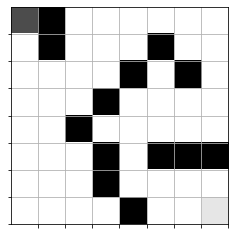

In [ ]:
completion_check(model, qmaze)
show(qmaze)

# # Check if the model passes the completion check
# if completion_check(model, qmaze):
#     print("Model successfully trained to completion.")
# else:
#     print("Model did not pass the completion check.")

#### This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure).<br><br>The treasure is located in the bottom-right corner.

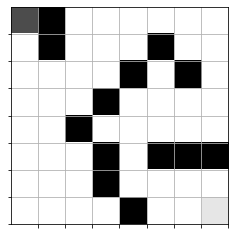

In [53]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

<!-- ## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks. -->

<hr>

## *Old versions of the qtrain function that I ended up not using but keeping for reference just incase*

<hr>

In [54]:
#
# Older versions below
#

# def qtrain(model, maze, **opt):
#     """
#     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
#     Parameters:
#     - model: The neural network model to be trained.
#     - maze: The maze environment as a NumPy array.
#     - **opt: Optional parameters including:
#         - n_epoch: Number of training epochs (default: 15000)
#         - max_memory: Maximum number of episodes to store in memory (default: 1000)
#         - data_size: Number of samples to train on per epoch (default: 50)
    
#     Returns:
#     - seconds: Total training time in seconds.
#     """
    
#     # Access the global exploration factor
#     global epsilon 
    
#     # Retrieve optional parameters or set to default values
#     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
#     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
#     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
#     # Record the start time to monitor training duration
#     start_time = datetime.datetime.now()
    
#     # Initialize the maze environment
#     qmaze = TreasureMaze(maze)
    
#     # Initialize the experience replay memory
#     experience = GameExperience(model, max_memory=max_memory)
    
#     # Initialize variables to track training progress
#     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
#     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
#     win_rate = 0.0                     # Current win rate
    
#     # Iterate over each epoch
#     for epoch in range(n_epoch):
#         # Randomly select a free cell as the pirate's starting position
#         agent_cell = random.choice(qmaze.free_cells)
        
#         # Reset the maze environment with the pirate at the selected starting position
#         qmaze.reset(agent_cell)
        
#         # Observe the current state of the environment
#         envstate = qmaze.observe()
        
#         # Initialize variables for the current episode
#         game_over = False               # Flag to determine if the game has ended
#         n_episodes = 0                  # Number of steps taken in the current epoch
#         win = False                     # Flag to indicate if the current episode is a win
        
#         # Continue interacting with the environment until the game is over
#         while not game_over:
#             # Store the previous state for experience replay
#             prev_envstate = envstate.copy()
            
#             # Decide whether to explore or exploit based on epsilon-greedy strategy
#             if random.random() < epsilon:
#                 # Exploration: choose a random valid action
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     action = random.choice(valid_actions)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
#             else:
#                 # Exploitation: choose the best action based on current Q-values
#                 q_values = experience.predict(prev_envstate)
                
#                 # Retrieve valid actions to mask invalid ones
#                 valid_actions = qmaze.valid_actions()
#                 if valid_actions:
#                     # Initialize Q-values for all actions as -infinity
#                     q_values_invalid = np.full(num_actions, -np.inf)
#                     # Assign actual Q-values to valid actions
#                     q_values_invalid[valid_actions] = q_values[valid_actions]
#                     # Select the action with the highest Q-value among valid actions
#                     action = np.argmax(q_values_invalid)
#                 else:
#                     # No valid actions available; the game is blocked
#                     action = None
            
#             # Execute the chosen action in the environment
#             if action is not None:
#                 envstate, reward, game_status = qmaze.act(action)
#             else:
#                 # Assign a penalty if the agent is blocked
#                 game_status = 'lose'
#                 reward = -1.0  # Penalty for being blocked
            
#             # Increment the number of steps taken
#             n_episodes += 1
            
#             # Determine if the game has ended
#             game_over = game_status in ['win', 'lose']
            
#             # Store the transition (episode) in experience replay memory
#             episode = [prev_envstate, action, reward, envstate, game_over]
#             experience.remember(episode)
            
#             # Update the win history if the game has ended
#             if game_over:
#                 win = 1 if game_status == 'win' else 0
#                 win_history.append(win)
        
#         # Train the neural network model if enough experiences are available
#         if len(experience.memory) >= data_size:
#             # Retrieve a batch of experiences for training
#             inputs, targets = experience.get_data(data_size=data_size)
            
#             # Train the model on the retrieved batch
#             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
#             # Extract the loss value from the training history
#             loss = history.history['loss'][0]
#         else:
#             # Not enough experiences to train; set loss to None
#             loss = None
        
#         # Calculate the win rate over the most recent hsize episodes
#         if len(win_history) >= hsize:
#             recent_wins = win_history[-hsize:]
#             win_rate = sum(recent_wins) / hsize
#         else:
#             recent_wins = win_history
#             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
#         # Calculate the elapsed time since training started
#         dt = datetime.datetime.now() - start_time
#         t = format_time(dt.total_seconds())
        
#         # Prepare the template for epoch information display
#         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
#         # Display loss as 0.0 if it's None to avoid formatting issues
#         loss_display = loss if loss is not None else 0.0
        
#         # Print the current epoch's training information
#         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
#         # Gradually decrease the exploration factor epsilon if the win rate is high
#         if win_rate > 0.9:
#             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
#         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
#         if win_rate == 1.0 and completion_check(model, qmaze):
#             print("Reached 100% win rate at epoch: {}".format(epoch+1))
#             break
    
#     # Calculate the total training time
#     dt = datetime.datetime.now() - start_time
#     seconds = dt.total_seconds()
#     t = format_time(seconds)
    
#     # Print the training summary
#     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
#     return seconds

# # def qtrain(model, maze, **opt):
# #     """
# #     Trains the pirate agent using Deep Q-Learning to navigate the maze and find the treasure.
    
# #     Parameters:
# #     - model: The neural network model to be trained.
# #     - maze: The maze environment as a NumPy array.
# #     - **opt: Optional parameters including:
# #         - n_epoch: Number of training epochs (default: 15000)
# #         - max_memory: Maximum number of episodes to store in memory (default: 1000)
# #         - data_size: Number of samples to train on per epoch (default: 50)
    
# #     Returns:
# #     - seconds: Total training time in seconds.
# #     """
    
# #     # Access the global exploration factor
# #     global epsilon 
    
# #     # Retrieve optional parameters or set to default values
# #     n_epoch = opt.get('n_epoch', 15000)          # Total number of training epochs
# #     max_memory = opt.get('max_memory', 1000)     # Maximum episodes to store in memory
# #     data_size = opt.get('data_size', 50)         # Number of training samples per epoch
    
# #     # Record the start time to monitor training duration
# #     start_time = datetime.datetime.now()
    
# #     # Initialize the maze environment
# #     qmaze = TreasureMaze(maze)
    
# #     # Initialize the experience replay memory
# #     experience = GameExperience(model, max_memory=max_memory)
    
# #     # Initialize variables to track training progress
# #     win_history = []                  # History of game outcomes (1 for win, 0 for loss)
# #     hsize = qmaze.maze.size // 2      # Window size for calculating win rate
# #     win_rate = 0.0                     # Current win rate
    
# #     # Iterate over each epoch
# #     for epoch in range(n_epoch):
# #         # Randomly select a free cell as the pirate's starting position
# #         agent_cell = random.choice(qmaze.free_cells)
        
# #         # Reset the maze environment with the pirate at the selected starting position
# #         qmaze.reset(agent_cell)
        
# #         # Observe the current state of the environment
# #         envstate = qmaze.observe()
        
# #         # Initialize variables for the current episode
# #         game_over = False               # Flag to determine if the game has ended
# #         n_episodes = 0                  # Number of steps taken in the current epoch
# #         win = False                     # Flag to indicate if the current episode is a win
        
# #         # Continue interacting with the environment until the game is over
# #         while not game_over:
# #             prev_envstate = envstate.copy()   # Store the previous state
            
# #             # Decide whether to explore or exploit based on epsilon-greedy strategy
# #             if random.random() < epsilon:
# #                 # Exploration: choose a random valid action
# #                 valid_actions = qmaze.valid_actions()
# #                 if valid_actions:
# #                     action = random.choice(valid_actions)
# #                 else:
# #                     # No valid actions available; the game is blocked
# #                     action = None
# #             else:
# #                 # Exploitation: choose the best action based on current Q-values
# #                 q_values = experience.predict(prev_envstate)
                
# #                 # Mask invalid actions by setting their Q-values to -infinity
# #                 valid_actions = qmaze.valid_actions()
# #                 if valid_actions:
# #                     q_values_invalid = np.full(num_actions, -np.inf)
# #                     q_values_invalid[valid_actions] = q_values[valid_actions]
# #                     action = np.argmax(q_values_invalid)
# #                 else:
# #                     # No valid actions available; the game is blocked
# #                     action = None
            
# #             # Execute the chosen action in the environment
# #             if action is not None:
# #                 envstate, reward, game_status = qmaze.act(action)
# #             else:
# #                 # Assign a penalty if the agent is blocked
# #                 game_status = 'lose'
# #                 reward = -1.0
            
# #             # Increment the number of steps taken
# #             n_episodes += 1
            
# #             # Determine if the game has ended
# #             game_over = game_status in ['win', 'lose']
            
# #             # Store the transition (episode) in experience replay memory
# #             episode = [prev_envstate, action, reward, envstate, game_over]
# #             experience.remember(episode)
            
# #             # Update the win history if the game has ended
# #             if game_over:
# #                 win = 1 if game_status == 'win' else 0
# #                 win_history.append(win)
        
# #         # Train the neural network model if enough experiences are available
# #         if len(experience.memory) >= data_size:
# #             # Retrieve a batch of experiences for training
# #             inputs, targets = experience.get_data(data_size=data_size)
            
# #             # Train the model on the retrieved batch
# #             history = model.fit(inputs, targets, epochs=1, verbose=0)
            
# #             # Extract the loss value from the training history
# #             loss = history.history['loss'][0]
# #         else:
# #             # Not enough experiences to train; set loss to None
# #             loss = None
        
# #         # Calculate the win rate over the most recent hsize episodes
# #         if len(win_history) >= hsize:
# #             recent_wins = win_history[-hsize:]
# #             win_rate = sum(recent_wins) / hsize
# #         else:
# #             recent_wins = win_history
# #             win_rate = sum(recent_wins) / len(recent_wins) if recent_wins else 0.0
        
# #         # Calculate the elapsed time since training started
# #         dt = datetime.datetime.now() - start_time
# #         t = format_time(dt.total_seconds())
        
# #         # Prepare the template for epoch information display
# #         template = "Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        
# #         # Display loss as 0.0 if it's None to avoid formatting issues
# #         loss_display = loss if loss is not None else 0.0
        
# #         # Print the current epoch's training information
# #         print(template.format(epoch+1, n_epoch, loss_display, n_episodes, sum(win_history[-hsize:]), win_rate, t))
        
# #         # Gradually decrease the exploration factor epsilon if the win rate is high
# #         if win_rate > 0.9:
# #             epsilon = max(epsilon * 0.995, 0.05)  # Ensure epsilon doesn't fall below 0.05
        
# #         # Early stopping condition: if win rate is 100% over the window and the agent passes the completion check
# #         if win_rate == 1.0 and completion_check(model, qmaze):
# #             print("Reached 100% win rate at epoch: {}".format(epoch+1))
# #             break
    
# #     # Calculate the total training time
# #     dt = datetime.datetime.now() - start_time
# #     seconds = dt.total_seconds()
# #     t = format_time(seconds)
    
# #     # Print the training summary
# #     print("Training completed in epoch: {}, max_memory: {}, data_size: {}, time: {}".format(epoch+1, max_memory, data_size, t))
    
# #     return seconds

# # #
# # # Original Version that came with the project pre-edits/ added qtrain function to impliment the Deep Q-Learning algorithm
# # #

# # # def qtrain(model, maze, **opt):

# # #     # exploration factor
# # #     global epsilon 

# # #     # number of epochs
# # #     n_epoch = opt.get('n_epoch', 15000)

# # #     # maximum memory to store episodes
# # #     max_memory = opt.get('max_memory', 1000)

# # #     # maximum data size for training
# # #     data_size = opt.get('data_size', 50)

# # #     # start time
# # #     start_time = datetime.datetime.now()

# # #     # Construct environment/game from numpy array: maze (see above)
# # #     qmaze = TreasureMaze(maze)

# # #     # Initialize experience replay object
# # #     experience = GameExperience(model, max_memory=max_memory)
    
# # #     win_history = []   # history of win/lose game
# # #     hsize = qmaze.maze.size//2   # history window size
# # #     win_rate = 0.0
    
# # #     # pseudocode:
# # #     # For each epoch:
# # #     #    Agent_cell = randomly select a free cell
# # #     #    Reset the maze with agent set to above position
# # #     #    Hint: Review the reset method in the TreasureMaze.py class.
# # #     #    envstate = Environment.current_state
# # #     #    Hint: Review the observe method in the TreasureMaze.py class.
# # #     #    While state is not game over:
# # #     #        previous_envstate = envstate
# # #     #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
# # #     #        envstate, reward, game_status = qmaze.act(action)
# # #     #    Hint: Review the act method in the TreasureMaze.py class.
# # #     #        episode = [previous_envstate, action, reward, envstate, game_status]
# # #     #        Store episode in Experience replay object
# # #     #    Hint: Review the remember method in the GameExperience.py class.
# # #     #        Train neural network model and evaluate loss
# # #     #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
# # #     #          to train the model. You can call model.evaluate to determine loss.
# # #     #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


# # #     #Print the epoch, loss, episodes, win count, and win rate for each epoch
# # #         dt = datetime.datetime.now() - start_time
# # #         t = format_time(dt.total_seconds())
# # #         template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
# # #         print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
# # #         # We simply check if training has exhausted all free cells and if in all
# # #         # cases the agent won.
# # #         if win_rate > 0.9 : epsilon = 0.05
# # #         if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
# # #             print("Reached 100%% win rate at epoch: %d" % (epoch,))
# # #             break
    
    
# # #     # Determine the total time for training
# # #     dt = datetime.datetime.now() - start_time
# # #     seconds = dt.total_seconds()
# # #     t = format_time(seconds)

# # #     print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
# # #     return seconds

# # # # This is a small utility for printing readable time strings:
# # # def format_time(seconds):
# # #     if seconds < 400:
# # #         s = float(seconds)
# # #         return "%.1f seconds" % (s,)
# # #     elif seconds < 4000:
# # #         m = seconds / 60.0
# # #         return "%.2f minutes" % (m,)
# # #     else:
# # #         h = seconds / 3600.0
# # #         return "%.2f hours" % (h,)